# Project for the 'Programming for Data Analysys'
***

### Table of content
[1. Problem statement](#par1)<br>
[2. Simulate the data using``numpy.random`` package](#par2)<br>
[2.1 Simulate single variable](#par2.1)<br>
[2.1.1 Perfect process](#par2.1.1)<br>
[2.1.1 Simulate 'special causes'](#par2.1.2)<br>
[2.2 Simulate scrap ratio based on 10 dimensions](#par2.2)<br>
[3. Analise the data](#par3)<br>
<hr>

### Import all the packages

In [1]:
# import all the packackes used in the notebook
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, colors
import seaborn as sns 
from scipy.stats import weibull_min, norm, ttest_ind, binom

import warnings
# For predicting the scrap in lot using machine learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, log_loss
from sklearn.exceptions import ConvergenceWarning

import MySPC as spc

In [2]:
# Create the new instance of the numpy psudorandom numbers Generator
rng = np.random.default_rng(19790627)

<a id="par1"></a>
## 1. Problem statement

For this project, I will simulate measurements of a dimensions created in the single machining process step. First, I will simulate a process' without a special cause variability and then I will simulate and add different sources of special cause variation. When all the dimensions for all the parts are generated, I will compare them with their Service Limits (tolerances) to determine whether or not the measurement is within the limits. If the measurement is above the Upper Service Limit or below Lower Service Limit, dimension is marked as scrap.

Variability in any manufacturing process can be divided into two distinct categories [1]: 
- Random, natural or inherent variability, which is naturally present in any process or system. This can be caused by machine vibration, natural changes in raw material hardness, fluctuations in the temperature, errors in machine axis encoders etc. Process that has only natural variability is called statistically stable process
- Assignable or special cause variability. This variability is not inherent part of the process, and the sources of this variability can be identified and removed from the process.

In the Section 2.1.1. I will stimulate a process that has only single dimension and only common causes of variability are present. This type of process can be described with a normal distribution.

In Section 2.1.2 I will be adding special (or assignable) sources of process variability. First I will add process bias (process not being cantered on its expected value), batch to batch variation caused by changes in the fixture setup, next variability caused by the cutting tool: differences in the tool size, tool wear and tool failure.

Finally, in section 2.2 I will simulate the measured dimensions from the manufacturing process with 20 independent variables that was ran for 30 days.

The following assumptions were made:
- Single manufacturing process step is modelled
- Each part has 10 dimensions that are independently measured
- If any of the 10 dimensions is measured outside of the specified limit (upper or lower service limit), part is scrapped
- Parts are manufactured in batches of 10

<a id="par2"></a>
## 2. Simulate the data using ```numpy.random``` package

<a id="par2.1"></a>
### 2.1 Simulate single variable

<a id="par2.1.1"></a>
#### 2.1.1 Process with with Inherent process variation only

Inherent Process Variation: the portion of the process variation that is due to common causes only [1].

##### Define Dim1 attributes

Process capability: the 6$\sigma$ range of the process's inherent variation (variation without the special causes).

$$
C_{p}=\frac{USL-LSL}{6\sigma}
$$

Given the process capability and upper and lower service limits, we can calculate the underlying process standard deviation:


$$
\sigma=\frac{USL-LSL}{6 C_{p}}
$$

##### Define the process and the inherent variation parameters

In [3]:
# Nominal dimension
mean = 9.5
# Upper and Lower tollerances
lsl, usl = 9.4, 9.6
# Process capability
cp = 2.
# Number of lots
nr_lots = 20
# Parts in the lot 
nr_in_lot = 10
# Total number of parts
n = nr_lots*nr_in_lot

##### Simulate the inherent process variation using normal distribution

In [4]:
# Simulate the measurements of single dimenension using normal distribution
# ccv stands for common cause variation
dim1 = pd.DataFrame({'ccv': rng.normal(mean, (usl-lsl)/(6*cp) , n)})

##### Show distribution of dim1 using Histogram

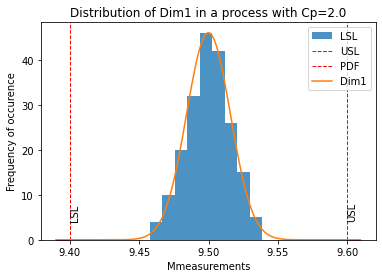

In [5]:
fig, ax = spc.hist(dim1, 'Dim1', lsl, usl, cp)

##### Check Dim1 with Statistical Process Control charts

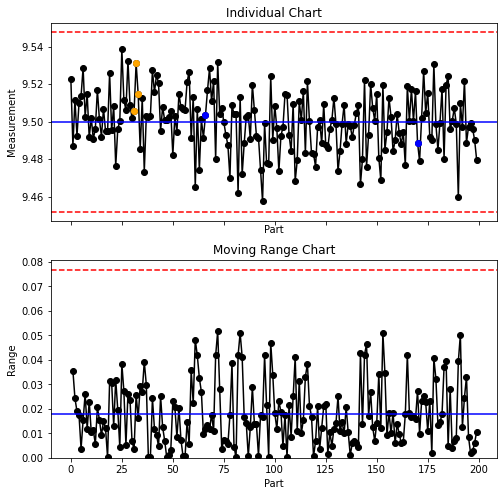

In [6]:
o = spc.xmr(dim1.loc[:,'ccv'])

##### Process not centered at nominal

More realistic scenarion would be a situation where the manufacturing process is not perfectly centered on the nominal value. This can be caused by:
- Lack of machine calibration
- Poor process design

In [7]:
# Simulate the effect of proces not being centered at the nominal
# The mean of such process would be pooled from normal distribution:

proc_mean=rng.normal(mean, (usl-lsl)/6)

dim1['ccv_off_center'] = dim1['ccv'] + mean - proc_mean

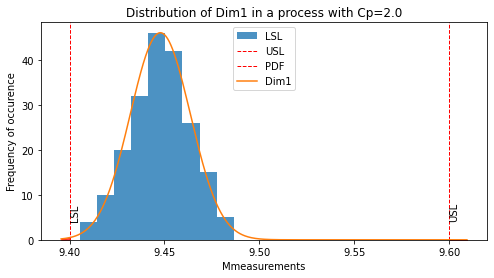

In [8]:
# As seen on the histogram plot, process without special causes variability is alredy not centered perfectly between upper and lower service limits
fig, ax = spc.hist(dim1['ccv_off_center'], 'Dim1', lsl, usl, cp)

<a id="par2.1.2"></a>
#### 2.1.2 Simulate 'special causes'

##### Variation between the batches

Vatiation between the batches can be casued by:
- difrences in the fixture setup
- changes in the raw material (material hardness, forging size etc)

Distribution of batch-to-batch variation is normal.

In [9]:
# define the ratio of batch-to-batch standard deviation to the dimension tolerance
# The larger the number, the smallest the effect of this special cause 
btb_sd_ratio = 20

# create a array with adjustment for each lot
lots = rng.normal(0, (usl-lsl)/btb_sd_ratio , nr_lots)

# add the same adjustment for each 'nr_in_lot' in a lot
part = 0
for l in lots:
    for p in range(nr_in_lot):
        dim1.loc[part, 'btb'] = l
        part = part + 1


# Create a 'measured' column by adding a batch-to-batch variation to the base ccv dimensions
dim1['measured'] = dim1['ccv_off_center'] + dim1['btb']

# Show data for parts in 2 first lots to make sure btb is calculated correctly       
dim1.head(2*nr_in_lot)

,ccv,ccv_off_center,btb,measured
0,9.522674,9.470523,-0.016868,9.453655
1,9.487141,9.434990,-0.016868,9.418122
2,9.511445,9.459294,-0.016868,9.442426
3,9.492488,9.440337,-0.016868,9.423469
4,9.509872,9.457721,-0.016868,9.440853
5,9.513610,9.461459,-0.016868,9.444591
6,9.528843,9.476692,-0.016868,9.459824
7,9.502752,9.450601,-0.016868,9.433733
8,9.514616,9.462465,-0.016868,9.445596
9,9.491630,9.439479,-0.016868,9.422611


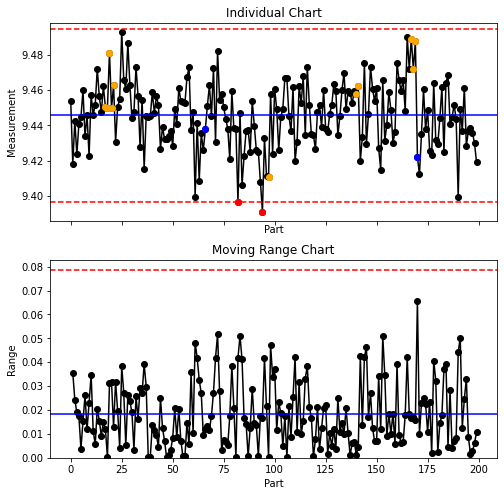

In [10]:
# Check the SPC chart for the measured dimension (common cause variation with batch-to-batch variation)
o = spc.xmr(dim1.loc[:,'measured'])

##### Effect of the tool size variation

Sizes of the tools are not identical, each cutting tool is manufactured within a certain manufacturing limit. Variation caused by the changes in the tool size are another common source of the special cause variation. This variation can be minimized using tool offset measuring devices.

In [11]:
# define tool life: how many lots can be processed by one tool
lots_per_tool = 4
# tool tolerance
# Example tool tolerances: http://www.mitsubishicarbide.com/en/technical_information/tec_rotating_tools/face_mills/tec_milling_guide/tec_milling_tolerance
tool_tol = 0.02

In [12]:
# Distribution of changes in tool sizes will be pooled from uniform distribution from interval -tool_tol to 0
nr_of_tools = int(np.ceil(nr_lots/lots_per_tool))
tools = rng.uniform(-tool_tol, 0 , nr_of_tools)

# add the same adjustment to each part processed by one tool: lots_per_tool * nr_in_lot - lots_per_tool is in number of lots
part = 0
for t in tools:
    for p in range(nr_in_lot * lots_per_tool):
        dim1.loc[part, 'tcv'] = t
        part = part + 1
        # when the ratio nr_lots/lots_per_tool is not an integer, additional rows would be created by this loop
        # exiting the loop when part count reaches nr_lots*nr_in_lot
        if part==nr_lots*nr_in_lot:
            break

# Sum all the variations:
dim1['measured'] = dim1['ccv_off_center'] + dim1['btb'] + dim1['tcv']

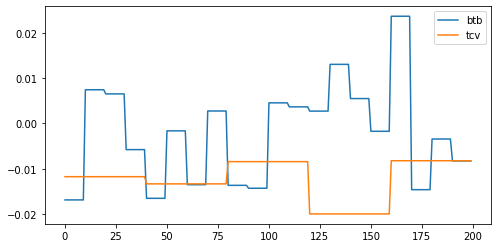

In [13]:
# Compare the impact from batch-to-batch variation with tool-change variation
dim1[['btb','tcv']].plot()
plt.show()

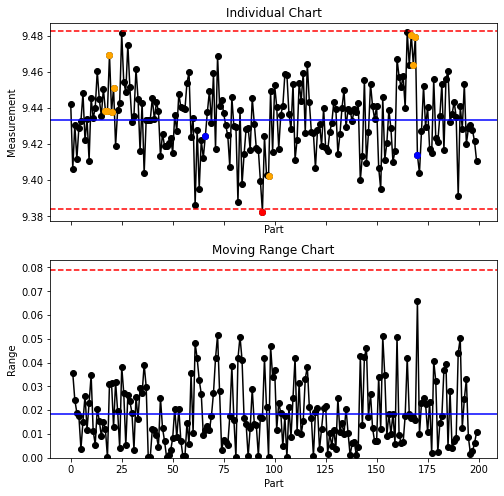

In [14]:
# Check the SPC chart for the measured dimension (common cause variation plus batch-to-batch variation and tool-change variation)
o = spc.xmr(dim1.loc[:,'measured'])

##### Effect of a tool wear

During the manufacturing process, cutting tool is designed to remove material from the processed part. This doesn’t happen without the tools itself wearing down as well.

In [15]:
# Tool wear can be aproximated with a linear model, as per:
# https://www.sciencedirect.com/science/article/pii/S235197891630049X/pdf?md5=de5447dd9c5745bc8a5638dc26d7d66c&pid=1-s2.0-S235197891630049X-main.pdf
# https://journals.sagepub.com/doi/pdf/10.1177/1687814017750434

# Define the maximum tool wear
max_tool_wear = 0.04

In [16]:
# Calculate the tool wear assuming linear tool-wear model
inc_wear = max_tool_wear/(nr_in_lot * lots_per_tool)

part = 0

for t in tools:
    # No tool wear for the firts part
    dim1.loc[part, 't_wear'] = 0
    for p in range(1, nr_in_lot * lots_per_tool):
        part = part + 1
        # pool a random number between 0 and inc_wear and add it to the previous part wear to calculate the total tool wear for current part
        dim1.loc[part, 't_wear'] =  dim1.loc[part-1, 't_wear'] + rng.uniform(0, inc_wear)
        # when the ratio nr_lots/lots_per_tool is not an integer, additional rows would be created by this loop
        # exiting the loop when part count reaches nr_lots*nr_in_lot
        if part==nr_lots*nr_in_lot:
            break

dim1['measured'] = dim1['ccv_off_center'] + dim1['btb'] + dim1['tcv'] + dim1['t_wear']           

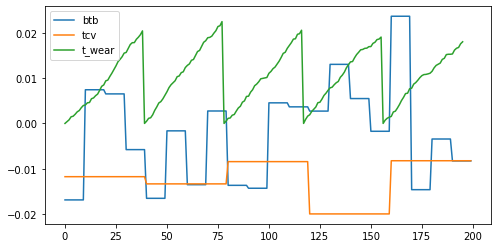

In [17]:
# Compare the impact from batch-to-batch variation, tool-change variation and tool wear
dim1[['btb','tcv', 't_wear']].plot()
plt.show()

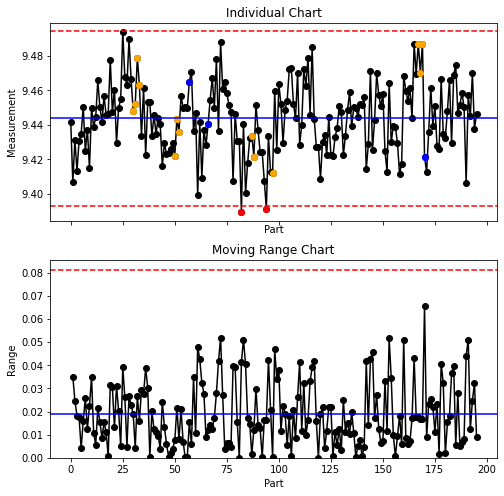

In [18]:
# Check the SPC chart for the measured dimension (common cause variation plus batch-to-batch variation and tool-change variation)
o = spc.xmr(dim1.loc[:,'measured'])

##### Model tool failure

Cutting tools sometimes fail catastrophically: part the cutting edge can break off and the tool loses its ability to cut the parts to specified dimension. Number of parts machined by each tool is designed to balance the risk of tool failure with the cost of the tools and potential scrap: the more expensive the tool is the closer to its limit it will be 'pushed' by the process designer; the more expensive the parts are to scrap, the more likely process will have large safety margin build in to minimize the risk of tool failure and damaging the parts.

Below, I have modelled the tool life (amount of parts tool can process before the failure) using Weibull distribution. Parameters of the Weibull distribution were selected to have 24.6% chance of tool breaking before the tool change. If the randomly pooled tool life is smaller or equal to the number of parts the tool is designed to cut (```nr_lots*nr_in_lot```) the tool is considered 'broken' and the rest of the parts processed by that tool will have the 'tool break variance' added, which is randomly pooled using normal distribution cantered at 0.1.

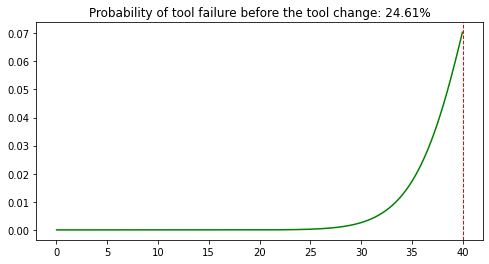

In [19]:
# Model number of parts machined by each tool using Weibull distribution
# https://www.researchgate.net/publication/226636244_Prediction_of_tool_failure_rate_in_turning_hardened_steels

# Shape parameter
a = 12  
# location parameter
mu = nr_in_lot * lots_per_tool * 0.1
# scale parameter
lam = nr_in_lot * lots_per_tool

# Round down to the nearest integer
tool_life = np.floor(weibull_min.rvs(a, loc=mu, scale=lam, size=nr_of_tools, random_state=rng))

# define the x axis of the plot
x = np.arange(1, 1000.)/1000.*lam

y = weibull_min.pdf(x, a, loc=mu, scale=lam)
plt.plot(x, y, color='green', label='Scaled cdf')
plt.title('Probability of tool failure before the tool change: {:.2%}'.format(weibull_min.cdf(40, a, loc=mu, scale=lam)))
plt.axvline(nr_in_lot * lots_per_tool, color='r', linestyle='dashed', linewidth=1)
plt.show()

In [20]:
# show the array of generated tool lifes (number of parts processed by tool before the failure)
tool_life

array([45., 44., 42., 45., 36.])

In [21]:
part = 0

dim1['t_break'] = 0

for tl in tool_life:
    # if tool life is greater than number of parts processed by tool:
    if tl>=nr_in_lot * lots_per_tool:
        part = part + nr_in_lot * lots_per_tool
        if part>=nr_lots*nr_in_lot:
            break        
    # if tool life is smaller than number of parts processed by tool:
    else:
        part = part + int(tl)
        if part>=nr_lots*nr_in_lot:
            break        
        for p in range(int(tl), nr_in_lot * lots_per_tool):
            # Assign random value from normal distribution centered around 0.1
            # Chipped cutting tool will have smaller size causing large shift in the machined size
            # but rougher edge will introduce more variation to the process
            dim1.loc[part, 't_break'] = rng.normal(0.1, 0.01)
            part = part + 1
            # when the ratio nr_lots/lots_per_tool is not an integer, additional rows would be created by this loop
            # exiting the loop when part count reaches nr_lots*nr_in_lot
            if part>=nr_lots*nr_in_lot:
                break
                
dim1['measured'] = dim1['ccv_off_center'] + dim1['btb'] + dim1['tcv'] + dim1['t_wear'] + dim1['t_break']

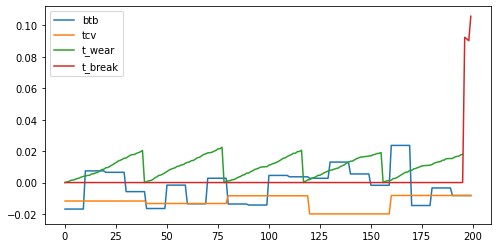

In [22]:
# Compare the impact from batch-to-batch variation, tool-change variation, tool wear and tool failure
dim1[['btb','tcv', 't_wear', 't_break']].plot()
plt.show()

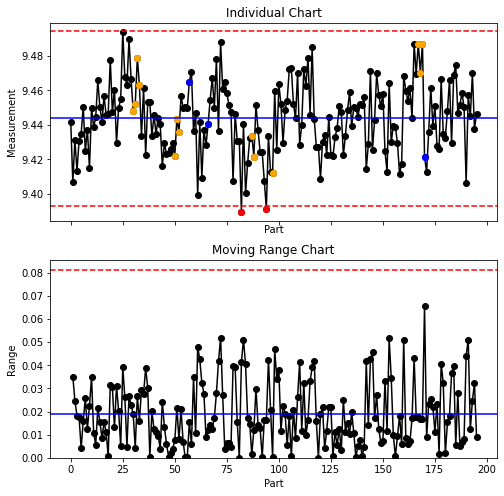

In [23]:
# Check the SPC chart for the measured dimension
o = spc.xmr(dim1.loc[:,'measured'])

### Calculate the Process Performance Index $P_{pk}$

The Process Performance Index $P_{pk}$ is calculated using the process total variation and it accounts for the process cantering. Typically it is calculated as:

$P_{pk} = min(P_{pl}, P_{pu})$

where:

$P_{pl} = \frac {Mean-LSL}{3\sigma}$ and $P_{pu} = \frac {USL-Mean}{3\sigma}$,

$\sigma$ is the total process variation (inherent variation plus the special cause variation)

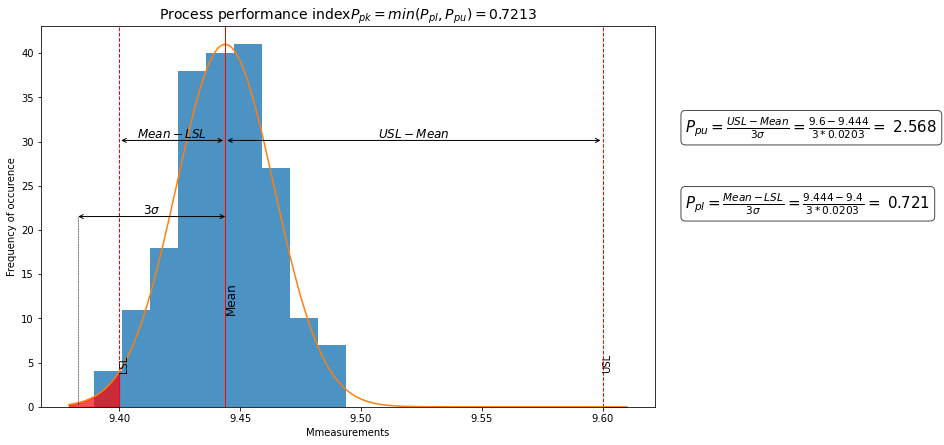

In [24]:
# Show distribution of the measurments with total process variation (Inherent plus special causes)

fig, ax = spc.hist(dim1['measured'], 'Dim1', lsl, usl, cp)

fig.set_size_inches(11, 7)

# Calculate the mean of the measured values
mean = dim1['measured'].mean()

#calculate the standard deviation of the measurements
sigma = dim1['measured'].std()

#calculate the Ppl and Ppu
ppl = (mean-lsl)/(3*sigma)
ppu = (usl-mean)/(3*sigma)

# Get the max y value of this plot
y_max = ax.get_ylim()[1]

ax.axvline(mean, color='r', linestyle='-', linewidth=1)
ax.text(mean, y_max/4, 'Mean',rotation=90, fontsize=12)

# Mathematical expressions in Matplotlib:
#https://matplotlib.org/stable/tutorials/text/mathtext.html
ax.set_title('Process performance index' + r'$P_{pk} = min(P_{pl}, P_{pu})= $' + '{:.4}'.format(min(ppl, ppu)), fontsize=14)

# ADD THE ANNOTATIONS THE THE PLOT

# draw an arrow from the lower service limit to the mean
ppl_line = ax.annotate("",
            xy=(lsl, y_max*0.7), xycoords='data',
            xytext=(mean, y_max*0.7), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3"),
            )

# add a text on top of the lsl-mean arrow
ppl_txt = ax.annotate(r'$Mean-LSL$', 
                      xy=((lsl + mean)/2, y_max*0.7), xycoords=("data"), 
                      horizontalalignment='center', verticalalignment='bottom',
                      fontsize=12
                     )

# draw an arrow from the upper service limit to the process mean
ppu_line = ax.annotate("",
            xy=(usl, y_max*0.7), xycoords='data',
            xytext=(mean, y_max*0.7), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3"),
            )

# add a text on top of the usl-mean arrow
ppl_txt = ax.annotate(r'$USL-Mean$', 
                      xy=((usl + mean)/2, y_max*0.7), xycoords=("data"), 
                      horizontalalignment='center', verticalalignment='bottom',
                      fontsize=12,
                     )


# select on which side of the mean to display the 3 sigma arrow, show it on the same side as calculation used for Ppk
if ppu<ppl:
    sign = 1
else:
    sign =-1

# draw a horizontal arrow to ilustrate the 3 sigma extent
sigma3_hline = ax.annotate("",
            xy=(mean+sign*3*sigma, y_max*0.5), xycoords='data',
            xytext=(mean, y_max*0.5), textcoords='data',
            arrowprops=dict(arrowstyle="<->", shrinkA = 0, shrinkB = 0, connectionstyle="arc3"),
            )


# calculate the height of the pdf function at mean+3*sigma
# normal pdf is simetrical, no need to include sign in the calculation
sigma3_y = y = norm.pdf(mean + 3*sigma, loc=mean, scale=sigma)

# draw a vertical line to show where 3 sigma lies on the pdf
sigma3_vline = ax.annotate("",
                           xy=(mean+sign*3*sigma, y_max*0.5), xycoords='data',
                           xytext=(mean+sign*3*sigma, sigma3_y), textcoords='data',
                           arrowprops=dict(arrowstyle="-", shrinkA = 0, shrinkB = 0, connectionstyle="arc3", linestyle = '--', linewidth = 0.5))

# Add the 3 Sigma text on the horizontal 3 sigma arrow
sigma3_txt = ax.annotate(r'$3\sigma$', 
                      xy=( (2*mean+sign*3*sigma)/2, y_max*0.5), xycoords=("data"), 
                      horizontalalignment='center', verticalalignment='bottom',
                      fontsize=12,
                     )

# Add an annotation on the side of the plot with the calculations for the Ppu
# https://stackoverflow.com/questions/33786332/matplotlib-using-variables-in-latex-expressions
desc = ax.annotate(r'$P_{pu} = \frac {USL-Mean}{3\sigma}$' + r'$ = \frac{{{:.4}-{:.4}}}{{3*{:.4f}}} =$ {:.3f}'.format(usl, mean, sigma, ppu),
                      xy=(1.05, 0.7), xycoords=("axes fraction"), 
                      horizontalalignment='left', verticalalignment='bottom',
                      fontsize=15,
                      bbox=dict(boxstyle="round", fc="w", alpha=0.7) 
                     )

# Add an annotation on the side of the plot with the calculations for the Ppl
desc = ax.annotate(r'$P_{pl} = \frac {Mean-LSL}{3\sigma}$' + r'$ = \frac{{{:.4}-{:.4}}}{{3*{:.4f}}} =$ {:.3f}'.format(mean,lsl, sigma, ppl),
                      xy=(1.05, 0.5), xycoords=("axes fraction"), 
                      horizontalalignment='left', verticalalignment='bottom',
                      fontsize=15,
                      bbox=dict(boxstyle="round", fc="w", alpha=0.7) 
                     )

# Remove the legend, as it's not needed and the plot would get too busy
legend = ax.legend()
legend.remove()

# Show the graph
plt.show()

$P_{pk}$ - the performance index which account for the process centering. It's determined by calculating partial indices $P_{pl}$ and $P_{pu}$ (as a fraction of a difference between the process mean and the Upper and Lower Service Limits and the 3 times the sample standard deviation) and then taking the lower value as $P_{pk}$.

### See the effect of each special cause variation on the measurement distribution

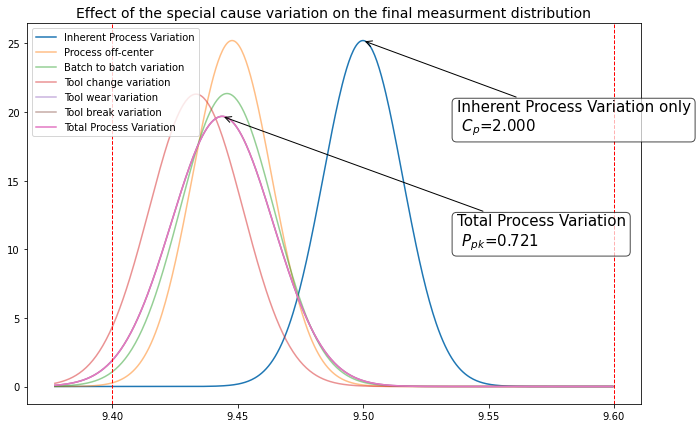

In [25]:
# Plot comparison for the Inherent Process Variation only and Total Process Variation

fig, ax = plt.subplots(figsize=(11,7))


ax.set_title('Effect of the special cause variation on the final measurment distribution', fontsize=14)

# Calculate the mean of the measured values
mean = dim1['measured'].mean()
mean_ccv = dim1['ccv'].mean()

#calculate the standard deviation of the measurements
sigma = dim1['measured'].std()
sigma_ccv = dim1['ccv'].std()

#Calculate the X axis limits to ensure that it includes the whole tollerance band and 99.9% of both distributions

# choose the x_min from lsl and the bottom intervals that contains 99.9% of both distributions
x_min = min(lsl, norm.interval(0.999, loc=mean, scale=sigma)[0], norm.interval(0.999, loc=mean_ccv, scale=sigma_ccv)[0])
# choose the x_max from usl and the top intervals that contains 99.9% of both distributions
x_max = max(usl, norm.interval(0.999, loc=mean, scale=sigma)[1], norm.interval(0.999, loc=mean_ccv, scale=sigma_ccv)[1])

#create a array of x values
x = np.arange(x_min, x_max, (x_max-x_min)/500. )


# Add distribution plot for the process with Inherent variation only
y_ccv = norm.pdf(x, loc=mean_ccv, scale=sigma_ccv)
ax.plot(x, y_ccv, label='Inherent Process Variation')

# Add distribution plot for the process with Inherent variation  and being off-center
y = norm.pdf(x, loc=dim1['ccv_off_center'].mean(), scale=dim1['ccv_off_center'].std())
ax.plot(x, y, label='Process off-center', alpha=0.5)

dim1['measured'] =  dim1['ccv_off_center'] + dim1['btb']

# Add distribution plot for the process with Inherent variation  and being off-center
y = norm.pdf(x, loc=dim1['measured'].mean(), scale=dim1['measured'].std())
ax.plot(x, y, label='Batch to batch variation', alpha=0.5)


dim1['measured'] =  dim1['measured'] + dim1['tcv']

# Add distribution plot for the process with Inherent variation  and being off-center
y = norm.pdf(x, loc=dim1['measured'].mean(), scale=dim1['measured'].std())
ax.plot(x, y, label='Tool change variation', alpha=0.5)


dim1['measured'] =  dim1['measured'] + dim1['t_wear']

# Add distribution plot for the process with Inherent variation  and being off-center
y = norm.pdf(x, loc=dim1['measured'].mean(), scale=dim1['measured'].std())
ax.plot(x, y, label='Tool wear variation', alpha=0.5)


dim1['measured'] =  dim1['measured'] + dim1['t_break']

# Add distribution plot for the process with Inherent variation  and being off-center
y = norm.pdf(x, loc=dim1['measured'].mean(), scale=dim1['measured'].std())
ax.plot(x, y, label='Tool break variation', alpha=0.5)


# Add the distribution plot for the final process, with inherent and all the special causes variation 
y = norm.pdf(x, loc=mean, scale=sigma)
ax.plot(x, y, label='Total Process Variation', alpha=1)



# Draw red vertical lines for upper and lower tolerances
ax.axvline(usl, color='r', linestyle='dashed', linewidth=1)
ax.axvline(lsl, color='r', linestyle='dashed', linewidth=1)

# Add the annotation for the Cp
desc = ax.annotate('Inherent Process Variation only\n '+r'$C_{p}$='+'{:.3f}'.format(cp),
                   xy=(mean_ccv, max(y_ccv)), xycoords= 'data',
                   xytext=(0.7, 0.7), textcoords= 'axes fraction',
                   arrowprops=dict(facecolor='black',  arrowstyle="->", connectionstyle="arc3"),
                   horizontalalignment='left', verticalalignment='bottom',
                   fontsize=15,
                   bbox=dict(boxstyle="round", fc="w", alpha=0.7)
                     )

# Add the annotation for the Ppk
desc = ax.annotate('Total Process Variation\n '+r'$P_{pk}$='+'{:.3f}'.format(min(ppl, ppu)),
                   xy=(mean, max(y)), xycoords= 'data',
                   xytext=(0.7, 0.4), textcoords= 'axes fraction',
                   arrowprops=dict(facecolor='black',  arrowstyle="->", connectionstyle="arc3"),
                   horizontalalignment='left', verticalalignment='bottom',
                   fontsize=15,
                   bbox=dict(boxstyle="round", fc="w", alpha=0.7)
                     )

# Add the legend
ax.legend(loc='upper left')

plt.show()

<a id="par2.2"></a>
### 2.2 Simulate 20 independent variables

All the above steps will be repeated for 20 independent variables. First, 20 process definitions will be randomly selected. These will include a random variables that will be selected only once, at the beginning of the experiment and they will not be changed through out the simulation:
- nominal dimensions, uniformly pooled from the interval of 3-10 (the nominal dimensions will be rounded to the first decimal place)
- corresponding tolerance bands selected form the set of values (0.02, 0.05, 0.10, 0.20) with relative frequencies (0.10, 0.20, 0.50, 0.20)
    - the Upper and Lower Service Limits are calculated as $USL = nominal + tolerance$ and $LSL = nominal - tolerance$
- process capability index $C_p$, pooled form normal distribution cantered at 2 with standard deviation of 0.5
- number of lots machined by a single tool (uniformly selected integer from the range of 1-9)
- tool tolerance (max value for the tool change variance) - selected randomly from the set of values: 0.01, 0.02 and 0.04
- maximum tool wear (max value for the tool wear variance) - selected randomly from the set of values: 0.01, 0.02 and 0.04
- Weibull distribution parameter for the tool life - randomly selected to create a random chance of tool failure from 1.5% to 24.6%

Once all the process parameters are defined, the main simulation part starts. All the steps are the same as in the single variable simulation above and are repeated for all the 20 variables. Simulation time is set to default of 30 days.
- first, process mean is randomly generated using normal distribution cantered at the nominal - this is to simulate the process not being cantered at nominal
- common cause variation (inherent process variation) is simulated by pooling the measurements from normal distribution cantered around process mean with a standard distribution of $std = \frac{tolerance}{6C_p}$
- once the measurements are simulated with common cause variation only, the following special cause variations are added:
    - batch to batch variation, its value is pooled for each lot from normal distribution cantered at 0
    - tool change, tool wear and tool break variation are added for each tool
- after all dimensions are generated, they are checked against the Upper and Lower Service Limits. If any of the dimensions is above LSL or above its USL, part is marked as scrap. 
- finally, number of scrapped parts per lot are calculated and analysed.

##### Define process step parameters

In [26]:
# Number of days
n_days = 30
# Numbers of batches (lots) manufactured in one day
nr_lots = 20
# Parts in a lot 
parts_in_lot = 10
# Total number of parts
n_parts = n_days* nr_lots * parts_in_lot
# Number of independent variables to be simulated:
n_dim = 20

#### 2.2.1 Create a table of process definitions

In [27]:
# Create a table of n_dim process definitions:

# list of typical tolerances used in manufacturing process and their typical frequency of use
tol_array = [0.02, 0.05, 0.10, 0.20]
tol_freq =  [0.10, 0.20, 0.50, 0.20]

dim_def = pd.DataFrame({'Nominal': np.round(rng.uniform(3, 10, n_dim), 1) })
dim_def['tolerance'] = rng.choice(tol_array, n_dim, p=tol_freq )
dim_def['LSL'] = dim_def['Nominal']-dim_def['tolerance']
dim_def['USL'] = dim_def['Nominal']+dim_def['tolerance']

dim_def['Cp'] = rng.normal(2, 0.5, n_dim)

# number of parts made by single tool will be pooled from natural numbers between 1 and 9:
dim_def['lots_per_tool'] = rng.choice(range(1,10), n_dim)

# tool tolerance will be randomly selected from the following list:
dim_def['tool_tol '] = rng.choice([0.01, 0.02, 0.04], n_dim)

# max tool wear per process randomly selected from the following values:
dim_def['max_tool_wear'] = rng.choice([0.01, 0.02, 0.04], n_dim)

# Tool failure probability from Webul distribution
a = 12
dim_def['tool_weibul_a'] = a
dim_def['tool_weibul_loc'] = parts_in_lot * dim_def['lots_per_tool'] * rng.uniform(0.1, 0.3, n_dim)
dim_def['tool_weibul_scale'] = parts_in_lot * dim_def['lots_per_tool']
dim_def['tool_failure_prob'] = weibull_min.cdf(parts_in_lot * dim_def['lots_per_tool'], a, loc=dim_def['tool_weibul_loc'], scale=dim_def['tool_weibul_scale'])

dim_def

,Nominal,tolerance,LSL,USL,Cp,lots_per_tool,tool_tol,max_tool_wear,tool_weibul_a,tool_weibul_loc,tool_weibul_scale,tool_failure_prob
0,7.1,0.10,7.00,7.20,1.730919,6,0.02,0.01,12,9.230079,60,0.126048
1,9.6,0.10,9.50,9.70,2.647246,2,0.02,0.01,12,4.787733,20,0.036800
2,6.5,0.02,6.48,6.52,2.505259,5,0.01,0.01,12,7.747996,50,0.124180
3,4.8,0.20,4.60,5.00,2.643472,4,0.02,0.01,12,8.522321,40,0.054843
4,9.8,0.10,9.70,9.90,1.498108,6,0.01,0.02,12,9.169905,60,0.127732
5,5.8,0.05,5.75,5.85,1.961452,9,0.04,0.04,12,10.901049,90,0.191353
6,8.4,0.02,8.38,8.42,1.482683,2,0.01,0.04,12,4.700365,20,0.039366
7,8.3,0.20,8.10,8.50,1.950624,7,0.02,0.01,12,15.517941,70,0.048215
8,6.3,0.10,6.20,6.40,2.266234,4,0.01,0.04,12,10.587224,40,0.024677
9,5.7,0.20,5.50,5.90,1.551987,9,0.02,0.04,12,25.122580,90,0.019496


####  2.2.2 Create a table with dimension measurements for all the features

##### Prepare DataFrame to hold all the measurements

In [28]:
# Create an all_dims Dataframe with a first columns: 'Date' and 'Lot'

days = []
lots = []

for day in range(n_days):
    for lot in range(nr_lots):        
        for part in range(parts_in_lot):
            # There will be 'parts_in_lot * nr_lots' parts made in every day, all these rows will have the same value in the 'Date' column
            days.append(day)
            # Make sure that lot number is unique for every batch
            lots.append(day*nr_lots + lot)
        
all_dims = pd.DataFrame({'Date': days, 'Lot': lots})

In [29]:
# Create a DataFrame to keep all the parameters for each lot and dimension
lot_parameters = pd.DataFrame({'Lot': all_dims['Lot'].unique()})
lot_parameters.set_index('Lot', inplace=True)

##### Run the simulation

In [30]:
# Simulate the n_dim number of features processed over n_days days:

all_parts = nr_lots*parts_in_lot*n_days

dim = pd.DataFrame(all_dims['Lot'])

# Iterate through the columns of all_dims DataFrame:
for dim_row, index in dim_def.iterrows():
    column = "Dim" + str(dim_row + 1)
    mean = index[0]
    tol = index[1] * 2
    cp = index[4]
    # Tool parameters:
    lots_per_tool = int(index[5])
    tool_tol = index[6]
    max_tool_wear = index[7]
    # Tool failure Weibull distribution parameters
    # Shape parameter
    a = index[8]
    # scale parameter
    mu = index[9]
    # location parameter
    lam = index[10]
    
    # Simulate the effect of proces not being centered at the nominal
    # The mean of such process would be pooled from normal distribution:
    proc_mean=rng.normal(mean, tol/6)
    
    dim['ccv'] = rng.normal(proc_mean, tol/(6*cp) , n_parts)
    #dim = pd.DataFrame({'ccv': rng.normal(proc_mean, tol/(6*cp) , n_parts)})
    
    # ADD BATCH TO BATCH VARIATION
    
    # define the ratio of batch-to-batch standard deviation to the dimension tolerance
    # The larger the number, the smallest the effect of this special cause 
    btb_sd_ratio = rng.normal(20, 5)

    # create an array with adjustment for mean for each lot
    lots = rng.normal(0, tol/btb_sd_ratio , nr_lots * n_days)
    
    #add the values of the batch to batch variation to lot_parameters DataFrame    
    col='btb'+str(dim_row + 1)
    lot_parameters[col] = lots
    

    # add the same adjustment for each 'parts_in_lot' in a lot
    part = 0
    for btb_l in lots:
        for p in range(parts_in_lot):
            dim.loc[part, 'btb'] = btb_l
            part = part + 1            

            
    #ADD TOOL CHANGE VARIATION and EFFECT OF A TOOL WEAR
    
    # Calculate the tool wear assuming linear tool-wear model
    inc_wear = max_tool_wear/(nr_in_lot * lots_per_tool)
    
    # Distribution of changes in tool sizes will be pooled from uniform distribution from interval -tool_tol to 0
    nr_of_tools = int(np.ceil(nr_lots * n_days/lots_per_tool))
    tools = rng.uniform(-tool_tol, 0 , nr_of_tools)

    # add tool variation parameter to lot_parameter DataFrame
    tw = pd.DataFrame({'tcv': tools})
    # as per https://stackoverflow.com/questions/49074021/repeat-rows-in-data-frame-n-times
    tw = tw.loc[tw.index.repeat(lots_per_tool)].reset_index(drop=True)
    
    col='tcv'+str(dim_row + 1)
    lot_parameters[col] = tw.iloc[:,0]
    
    part = 0
    for t in tools:
        # No tool wear for the firts part processed by given tool
        dim.loc[part, 't_wear'] = 0
        for p in range(parts_in_lot * lots_per_tool):
            dim.loc[part, 'tcv'] = t           
            part = part + 1
            # when the ratio nr_lots/lots_per_tool is not an integer, additional rows would be created by this loop
            # exiting the loop when part count reachesall_parts = nr_lots*parts_in_lot*n_days
            if part==all_parts:
                break
            dim.loc[part, 't_wear'] =  dim.loc[part-1, 't_wear'] + rng.uniform(0, inc_wear) 
    
    
    
    # ADD EFFECT OF EARLY TOOL FAILURE


    # tool_life: number of processed part before tool failure, rounded down to the nearest integer:
    tool_life = np.floor(weibull_min.rvs(a, loc=mu, scale=lam, size=nr_of_tools, random_state=rng))
    # initialize 't_break' column with all 0s
    dim['t_break'] = 0  
    
    # reset the part count
    part = 0
    for tl in tool_life:
        # if tool life is greater than number of parts processed by tool:
        if tl>=parts_in_lot * lots_per_tool:
            # increase the part count by number of parts processed by the tool
            part = part + parts_in_lot * lots_per_tool
            if part>=nr_lots*nr_in_lot:
                break        
        # if tool life is smaller than number of parts processed by tool:
        else:
            part = part + int(tl)
            if part>=nr_lots*nr_in_lot:
                break
            # Step through all the parts from in the range from tool Life to maximum processed by the tool    
            for p in range(int(tl), nr_in_lot * lots_per_tool):
                # Assign random value from normal distribution centered around 0.1
                # Chipped cutting tool will have smaller size causing large shift in the machined size
                # but rougher edge will introduce more variation to the process
                dim.loc[part, 't_break'] = rng.normal(0.1, 0.01)
                part = part + 1
                # when the ratio nr_lots/lots_per_tool is not an integer, additional rows would be created by this loop
                # exiting the loop when part count reaches nr_lots*nr_in_lot
                if part>=nr_lots*nr_in_lot:
                    break
    
    #add True to t_break column if Lot has parts machined with broken tool    
    col='t_break'+str(dim_row + 1)
    lot_parameters[col] = dim.groupby('Lot')['t_break'].sum()>0
    
    # ADD EFFECT OF COMMON CAUSES VARIATION AND ALL SPECIAL CAUSES 

    # Create a 'measured' column by adding a batch-to-batch variation to the base ccv dimensions
    all_dims[column] = dim['ccv'] + dim['btb'] + dim['tcv'] + dim['t_wear'] + dim['t_break']  

In [31]:
# Show simulated measurements
all_dims

,Date,Lot,Dim1,Dim2,Dim3,Dim4,Dim5,Dim6,Dim7,Dim8,...,Dim11,Dim12,Dim13,Dim14,Dim15,Dim16,Dim17,Dim18,Dim19,Dim20
0,0,0,7.071168,9.590344,6.495402,4.839063,9.791137,5.785946,8.407766,8.187858,...,7.398560,9.819377,5.700575,7.178014,8.120333,4.619912,5.602165,5.886841,7.082419,7.008725
1,0,0,7.068332,9.600589,6.495660,4.849092,9.752763,5.767893,8.392729,8.178518,...,7.389451,9.816742,5.700729,7.178665,8.113869,4.661094,5.593889,5.889452,7.085332,7.031575
2,0,0,7.097870,9.602247,6.496434,4.851729,9.775836,5.765512,8.392658,8.252606,...,7.395883,9.824472,5.723658,7.175358,8.114870,4.627123,5.596801,5.893201,7.088673,7.027848
3,0,0,7.081384,9.584905,6.491417,4.853822,9.807694,5.765236,8.394649,8.211694,...,7.398430,9.816772,5.710687,7.180397,8.127105,4.635947,5.605501,5.891768,7.089468,7.042363
4,0,0,7.110822,9.574328,6.494163,4.864644,9.787089,5.766129,8.403916,8.210554,...,7.394832,9.808025,5.704673,7.176006,8.113839,4.618263,5.600092,5.891845,7.087800,7.031790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,29,599,7.121980,9.596740,6.499603,4.815742,9.851246,5.805398,8.396371,8.257323,...,7.416605,9.807103,5.765708,7.212520,8.110794,4.621639,5.590499,5.899651,7.095382,7.015461
5996,29,599,7.095345,9.589513,6.501714,4.778171,9.814811,5.815517,8.404462,8.278292,...,7.412604,9.809940,5.753051,7.213762,8.112287,4.640294,5.595010,5.906524,7.107144,6.993737
5997,29,599,7.122001,9.603184,6.502995,4.818015,9.809587,5.811964,8.412904,8.229101,...,7.413211,9.815090,5.781101,7.209336,8.108434,4.682460,5.594223,5.906561,7.100713,7.005580
5998,29,599,7.082841,9.627443,6.505296,4.810038,9.812543,5.811841,8.409508,8.284257,...,7.415874,9.806307,5.777262,7.213162,8.117792,4.651732,5.591990,5.903735,7.102951,6.995567


Values of 20 dimensions were generated for 6000 parts in 600 lots machined over 30 days. In the next step, we'll analyse the data.

<a id="par3"></a>
## 3. Analyse the data

##### Mark non-conformant (scrapped) parts in the all_dims table

Check all the generated dimensions against their respective Upper and Lower Service limits (defined as $USL/LSL = nominal \pm tolerance$). If a dimension is smaller than LSL or greater than USL, dimension is marked as out of spec. If at least one dimension is out of spec in a single part, the whole part is scrapped.

In [32]:
# Check if any of the generated dimensions in each part is outside of tolerance band
# Mark part as scrap if at least one dimension is outside of tolerance

all_dims['Scrap_all'] = False
for row, index in dim_def.iterrows():
    # Iterate through dim_def table and set the Upper and Lower Service Limits
    lsl = dim_def.iloc[row, 2]
    usl = dim_def.iloc[row, 3]
    # Compare the measurement (column by column from all_dims) against the Service Limits
    all_dims['Scrap' + str(row+1)] = (lsl > all_dims['Dim'+str(row+1)]) | (all_dims['Dim'+str(row+1)] > usl)
    all_dims['Scrap_all'] = all_dims['Scrap_all'] | all_dims['Scrap' + str(row+1)]

##### Plot number of scrapped parts per day

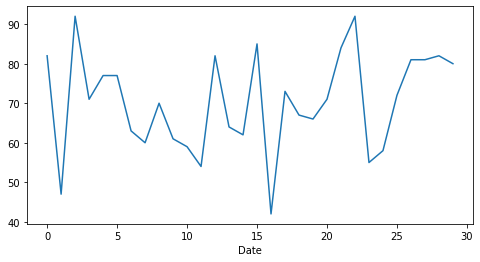

In [33]:
# Visualise amount of scraped part in every day
all_dims.groupby('Date').sum()['Scrap_all'].plot()
plt.show()

##### Join the number of scrapped parts to the 'lot_parameters' table

In [34]:
# Add scrapped parts per lot for each dimension to the lot_parameters dataframe
lot_parameters = lot_parameters.join(all_dims.groupby('Lot').sum().iloc[:,-(n_dim+1):])

In [35]:
# See the lot_parameters table
lot_parameters

,btb1,tcv1,t_break1,btb2,tcv2,t_break2,btb3,tcv3,t_break3,btb4,...,Scrap11,Scrap12,Scrap13,Scrap14,Scrap15,Scrap16,Scrap17,Scrap18,Scrap19,Scrap20
Lot,,,,,,,,,,,,,,,,,,,,,
0,-0.009567,-0.019356,False,-0.007441,-0.016469,False,-0.000539,-0.00639,False,0.009555,...,0,0,10,0,0,0,0,0,0,0
1,-0.006656,-0.019356,False,-0.002564,-0.016469,False,-0.000687,-0.00639,False,-0.012242,...,0,0,4,0,0,0,0,0,0,0
2,-0.022336,-0.019356,False,-0.002149,-0.006613,False,0.000995,-0.00639,False,-0.010484,...,0,0,2,0,0,0,0,0,0,0
3,-0.006511,-0.019356,False,-0.002494,-0.006613,False,0.001508,-0.00639,False,0.012162,...,0,0,0,0,0,0,0,0,0,0
4,-0.006110,-0.019356,False,-0.020406,-0.004431,False,0.002199,-0.00639,False,0.003741,...,0,0,1,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.015399,-0.004548,False,-0.006433,-0.017469,False,-0.000052,-0.00440,False,0.015113,...,0,0,0,0,0,0,0,0,0,0
596,0.021248,-0.004548,False,-0.001334,-0.002672,False,-0.002584,-0.00440,False,-0.023156,...,0,0,3,0,0,0,1,0,0,0
597,-0.003762,-0.004548,False,-0.001079,-0.002672,False,0.000845,-0.00440,False,-0.015233,...,0,0,4,0,0,0,0,0,0,0


In [36]:
# Find the data points that violate any of the SPC rules
for row, index in dim_def.iterrows():
    column = "Dim" + str(row + 1)
    # Show=False, don't plot the charts, there's too many of them
    xb = spc.xBarS(all_dims, column, 120, Show=False)
    # Add the St_dev, Mean and triggered SPC rule to the lot_parameters df
    lot_parameters["St_dev"+str(row + 1)] = xb['variability']
    lot_parameters["SPC_Rule"+str(row + 1)] = xb['Reason']
    lot_parameters["Mean"+str(row + 1)] = xb['Dim']

C:\Users\Przemek\AppData\Local\Temp/ipykernel_27840/114037206.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  lot_parameters["St_dev"+str(row + 1)] = xb['variability']
C:\Users\Przemek\AppData\Local\Temp/ipykernel_27840/114037206.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  lot_parameters["SPC_Rule"+str(row + 1)] = xb['Reason']
C:\Users\Przemek\AppData\Local\Temp/ipykernel_27840/114037206.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which

##### Create 'lot_params2' DataFrame

lot_params2 DataFrame will have all the data from 'lot_parameters', but instead of having separate column for each dimension parameter, 'dim' column will be added and only 6 columns will be needed:
- btb
- tcv
- t_break
- SPC_Rule
- Scrap
- St_dev

Additionaly, the following columns will be added to lot_params2 from the 'dim_def' table:
- tolerance
- Cp'  
- lots_per_tool
- tool_tol 
- max_tool_wear

In [37]:
lot_parameters

,btb1,tcv1,t_break1,btb2,tcv2,t_break2,btb3,tcv3,t_break3,btb4,...,Mean17,St_dev18,SPC_Rule18,Mean18,St_dev19,SPC_Rule19,Mean19,St_dev20,SPC_Rule20,Mean20
Lot,,,,,,,,,,,,,,,,,,,,,
0,-0.009567,-0.019356,False,-0.007441,-0.016469,False,-0.000539,-0.00639,False,0.009555,...,5.599786,0.003262,00001,5.891414,0.003739,00001,7.088481,0.014250,00001,7.020415
1,-0.006656,-0.019356,False,-0.002564,-0.016469,False,-0.000687,-0.00639,False,-0.012242,...,5.600351,0.002477,00001,5.890458,0.003590,00000,7.092240,0.011446,00000,7.014184
2,-0.022336,-0.019356,False,-0.002149,-0.006613,False,0.000995,-0.00639,False,-0.010484,...,5.597795,0.004006,00001,5.891172,0.004361,00001,7.089331,0.013002,00000,7.013936
3,-0.006511,-0.019356,False,-0.002494,-0.006613,False,0.001508,-0.00639,False,0.012162,...,5.601296,0.002989,00001,5.894582,0.003881,00010,7.097065,0.014084,00000,6.991920
4,-0.006110,-0.019356,False,-0.020406,-0.004431,False,0.002199,-0.00639,False,0.003741,...,5.602642,0.002893,00000,5.897010,0.003372,00001,7.100037,0.019444,00011,7.017752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.015399,-0.004548,False,-0.006433,-0.017469,False,-0.000052,-0.00440,False,0.015113,...,5.586748,0.002220,00001,5.893129,0.003186,00000,7.092841,0.010059,00000,7.000749
596,0.021248,-0.004548,False,-0.001334,-0.002672,False,-0.002584,-0.00440,False,-0.023156,...,5.583362,0.003462,00000,5.895761,0.002608,00000,7.095355,0.013511,00000,7.007174
597,-0.003762,-0.004548,False,-0.001079,-0.002672,False,0.000845,-0.00440,False,-0.015233,...,5.591723,0.003831,00011,5.901954,0.003068,00001,7.098107,0.012855,00000,6.995213


In [38]:
# Define empty 'lot_params2' DataFrame
lot_params2 = pd.DataFrame({'btb':{}, 'tcv':{}, 't_break':{}, 'SPC_Rule':{}, 'Scrap':{}, 'Mean':{}, 'St_dev':{}, 'dim':{}, 'Nominal':{}, 'tolerance':{}, 'Cp':{}, 'lots_per_tool':{}, 'tool_tol ':{}, 'max_tool_wear':{} })

In [39]:
# Iterate through all the dimensions 
for row, index in dim_def.iterrows():
    # dimension idndices start from 1
    dim_index = row + 1
    # create a string version of the dimension index
    n = str(dim_index)
    
    # create a temporary DataFrame to hold a slice of the 'lot_parameters' table relating to the n-th dimension
    dim = pd.DataFrame(lot_parameters[['btb'+n, 'tcv'+n, 't_break'+n, 'SPC_Rule'+n, 'St_dev'+n, 'Scrap'+n, 'Mean'+n]])
    
    # Change the column names in the temporary DataFrame to match lot_params2
    dim = dim.rename(columns = { 'btb'+n:'btb', 'tcv'+n:'tcv', 't_break'+n:'t_break', 'SPC_Rule'+n:'SPC_Rule', 'St_dev'+n:'St_dev', 'Scrap'+n:'Scrap', 'Mean'+n:'Mean' })
    # Add the dimension index
    dim['dim'] = dim_index
    
    # Add the 'tolerance', 'Cp', 'lots_per_tool', 'tool_tol', 'max_tool_wear' from the dim_def table
    # these are not changing between the lots and are defined per dimension
    dim['tolerance'] = dim_def.loc[row, 'tolerance']
    dim['Cp'] = dim_def.loc[row, 'Cp']    
    dim['lots_per_tool'] = dim_def.loc[row, 'lots_per_tool']
    dim['tool_tol '] = dim_def.loc[row, 'tool_tol ']
    dim['max_tool_wear'] = dim_def.loc[row, 'max_tool_wear']
    dim['Nominal'] = dim_def.loc[row, 'Nominal']
    
    # Append the temporary DataFrame to the lot_params2
    lot_params2 = lot_params2.append(dim)

In [40]:
lot_params2

,btb,tcv,t_break,SPC_Rule,Scrap,Mean,St_dev,dim,Nominal,tolerance,Cp,lots_per_tool,tool_tol,max_tool_wear
0,-0.009567,-0.019356,0.0,00001,0.0,7.094371,0.018675,1.0,7.1,0.1,1.730919,6.0,0.02,0.01
1,-0.006656,-0.019356,0.0,00000,0.0,7.104997,0.018840,1.0,7.1,0.1,1.730919,6.0,0.02,0.01
2,-0.022336,-0.019356,0.0,00001,0.0,7.089175,0.021956,1.0,7.1,0.1,1.730919,6.0,0.02,0.01
3,-0.006511,-0.019356,0.0,00001,0.0,7.099680,0.022469,1.0,7.1,0.1,1.730919,6.0,0.02,0.01
4,-0.006110,-0.019356,0.0,00000,0.0,7.110652,0.022242,1.0,7.1,0.1,1.730919,6.0,0.02,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.005041,-0.012023,0.0,00000,0.0,7.000749,0.010059,20.0,7.0,0.1,2.355062,6.0,0.02,0.01
596,0.002798,-0.012023,0.0,00000,0.0,7.007174,0.013511,20.0,7.0,0.1,2.355062,6.0,0.02,0.01
597,-0.007176,-0.012023,0.0,00000,0.0,6.995213,0.012855,20.0,7.0,0.1,2.355062,6.0,0.02,0.01
598,0.000207,-0.012023,0.0,00000,0.0,7.003070,0.011100,20.0,7.0,0.1,2.355062,6.0,0.02,0.01


In [41]:
# Calculate the Process performance to the Lower tolerance 
lot_params2['Ppl']= (lot_params2['Mean'] - (lot_params2['Nominal'] - lot_params2['tolerance'] ) )/(3 * lot_params2['St_dev'])

In [42]:
# Calculate the Process performance to the Upper tolerance
lot_params2['Ppu']= ( lot_params2['Nominal'] + lot_params2['tolerance'] - lot_params2['Mean'] )/(3 * lot_params2['St_dev'])

In [43]:
# Calculate Ppk, as a smaller value from Ppl and Ppu
# https://stackoverflow.com/questions/33975128/pandas-get-the-row-wise-minimum-value-of-two-or-more-columns
lot_params2['Ppk'] = lot_params2[['Ppl','Ppu']].min(axis=1)

In [44]:
# Drop the columns 'Nominal', 'Mean', 'Ppl' and  'Ppu'. These were only needed to calculate the Ppk value
lot_params2.drop(columns={'Nominal', 'Mean', 'Ppl', 'Ppu'}, inplace=True)

###### Unpack the SPC_Rule column into 5 separate columns, one for each SPC rule

In [45]:
for i in range(1,6):
    lot_params2['SPC_Rule' + str(i)] = lot_params2['SPC_Rule'].str[-i].astype(int)

In [46]:
# Re-purpose the 'SPC_Rule' column
lot_params2['SPC_Rule'] = lot_params2['SPC_Rule1']+lot_params2['SPC_Rule2']+lot_params2['SPC_Rule3']+lot_params2['SPC_Rule3']+lot_params2['SPC_Rule5']

In [47]:
#See the final 'lot_params2' table
lot_params2

,btb,tcv,t_break,SPC_Rule,Scrap,St_dev,dim,tolerance,Cp,lots_per_tool,tool_tol,max_tool_wear,Ppk,SPC_Rule1,SPC_Rule2,SPC_Rule3,SPC_Rule4,SPC_Rule5
0,-0.009567,-0.019356,0.0,1,0.0,0.018675,1.0,0.1,1.730919,6.0,0.02,0.01,1.684450,1,0,0,0,0
1,-0.006656,-0.019356,0.0,0,0.0,0.018840,1.0,0.1,1.730919,6.0,0.02,0.01,1.680872,0,0,0,0,0
2,-0.022336,-0.019356,0.0,1,0.0,0.021956,1.0,0.1,1.730919,6.0,0.02,0.01,1.353839,1,0,0,0,0
3,-0.006511,-0.019356,0.0,1,0.0,0.022469,1.0,0.1,1.730919,6.0,0.02,0.01,1.478793,1,0,0,0,0
4,-0.006110,-0.019356,0.0,0,0.0,0.022242,1.0,0.1,1.730919,6.0,0.02,0.01,1.339025,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.005041,-0.012023,0.0,0,0.0,0.010059,20.0,0.1,2.355062,6.0,0.02,0.01,3.288876,0,0,0,0,0
596,0.002798,-0.012023,0.0,0,0.0,0.013511,20.0,0.1,2.355062,6.0,0.02,0.01,2.290127,0,0,0,0,0
597,-0.007176,-0.012023,0.0,0,0.0,0.012855,20.0,0.1,2.355062,6.0,0.02,0.01,2.468963,0,0,0,0,0
598,0.000207,-0.012023,0.0,0,0.0,0.011100,20.0,0.1,2.355062,6.0,0.02,0.01,2.910785,0,0,0,0,0


### Show 2 best performing processes (based on $P_{pk}$ values)

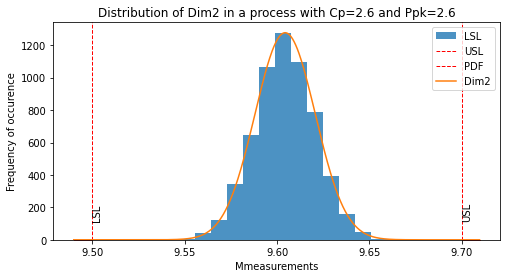

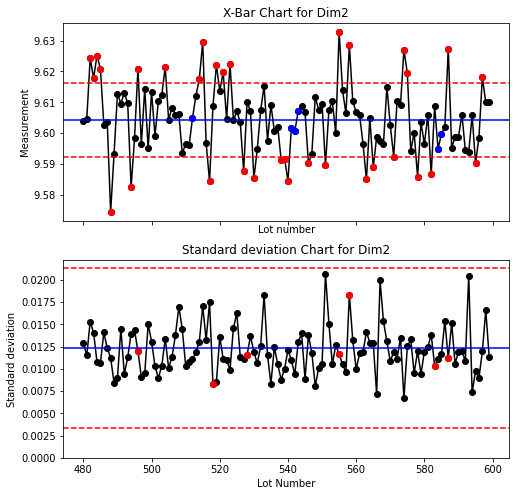

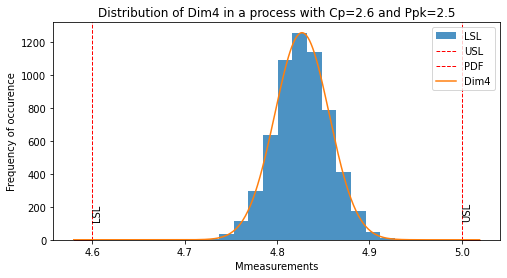

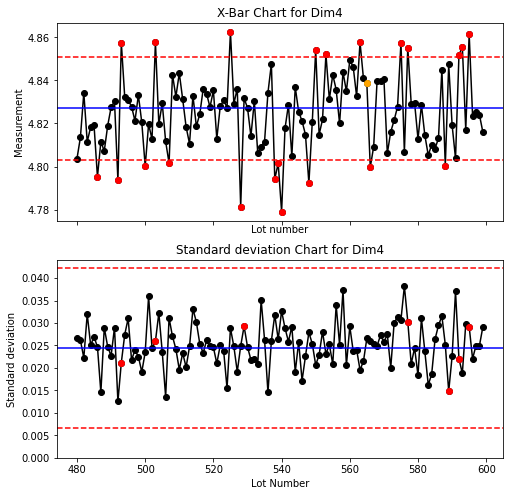

In [48]:
# Find 2 dimensions with the Highest Ppk
worst = lot_params2.groupby('dim').mean().sort_values(by='Ppk', ascending=False).iloc[0:2]

# Show  dimensions distribution on histogram with LSL and USL marked
for row, index in worst.iterrows():
    column = "Dim" + str(int(row))
    spc.hist(all_dims[column], column, dim_def.loc[row-1,'LSL'], dim_def.loc[row-1,'USL'], dim_def.loc[row-1,'Cp'], worst.loc[row, 'Ppk'])
    xb = spc.xBarS(all_dims, column, 120)

### Show 2 best performing processes (based on SPC rules)

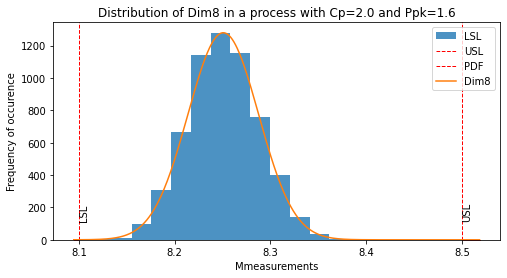

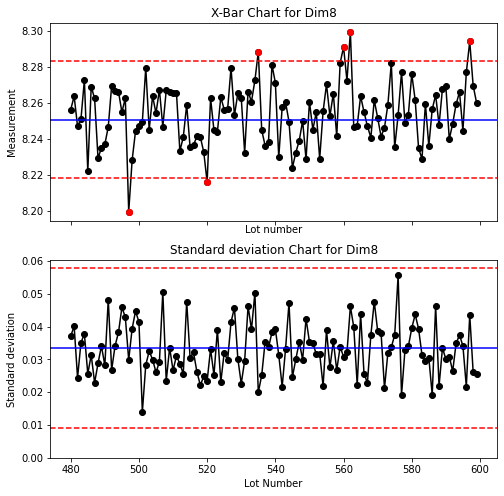

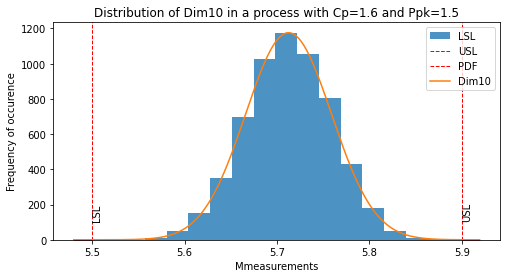

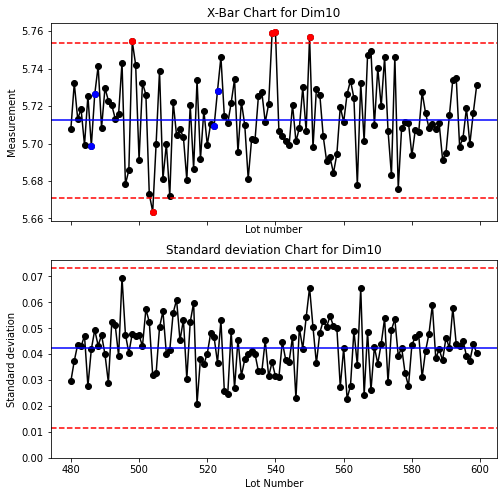

In [49]:
# Find 2 dimensions with the lowest total count of SPC Rules violations
worst = lot_params2.groupby('dim').mean().sort_values(by='SPC_Rule', ascending=True).iloc[0:2]

# Show  dimensions distribution on histogram with LSL and USL marked
for row, index in worst.iterrows():
    column = "Dim" + str(int(row))
    spc.hist(all_dims[column], column, dim_def.loc[row-1,'LSL'], dim_def.loc[row-1,'USL'], dim_def.loc[row-1,'Cp'], worst.loc[row, 'Ppk'])
    xb = spc.xBarS(all_dims, column, 120)

### Show 2 worst performing processes (based on $P_{pk}$ values)

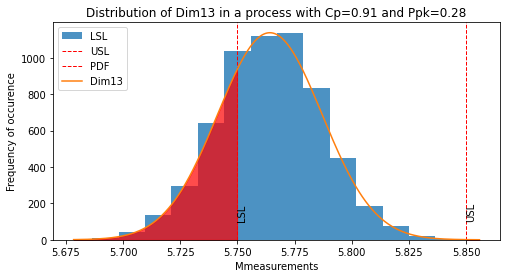

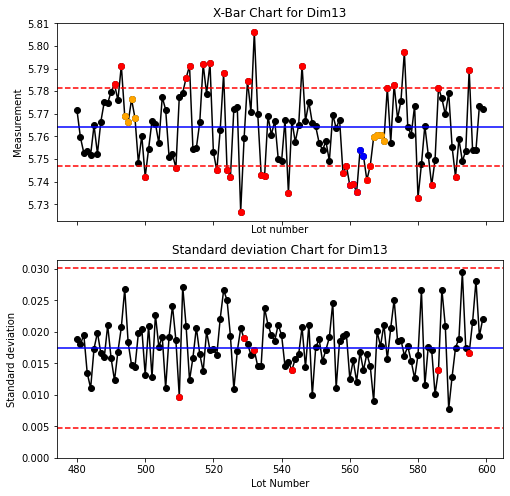

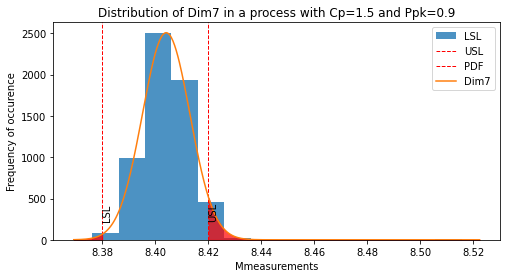

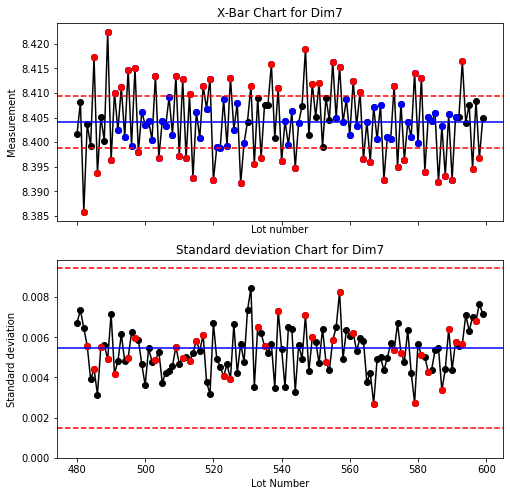

In [50]:
# Find 2 dimensions with the lowest Ppk
worst = lot_params2.groupby('dim').mean().sort_values(by='Ppk', ascending=True).iloc[0:2]

# Show  dimensions distribution on histogram with LSL and USL marked
for row, index in worst.iterrows():
    column = "Dim" + str(int(row))
    spc.hist(all_dims[column], column, dim_def.loc[row-1,'LSL'], dim_def.loc[row-1,'USL'], dim_def.loc[row-1,'Cp'], worst.loc[row, 'Ppk'])
    xb = spc.xBarS(all_dims, column, 120)

### Show 2 worst performing processes (based on SPC rules)

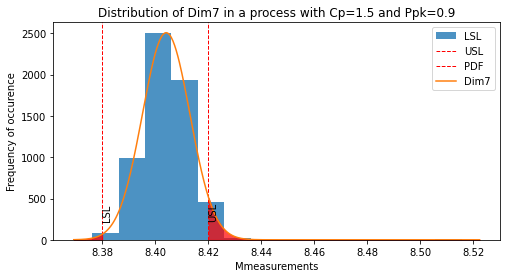

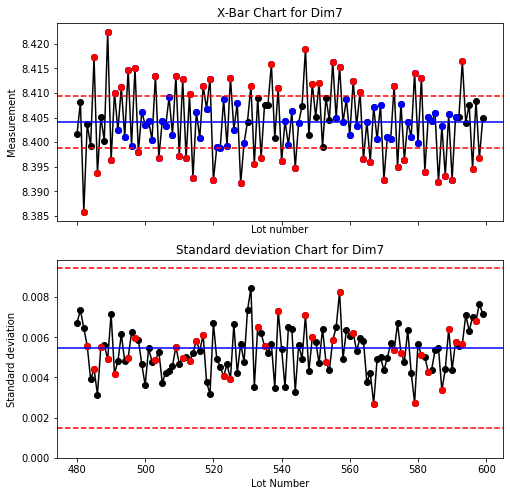

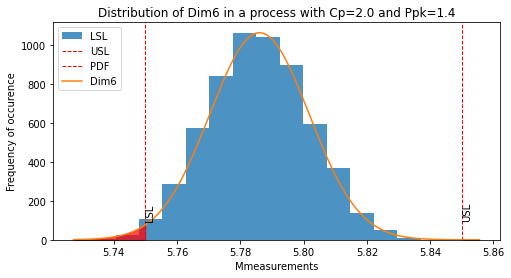

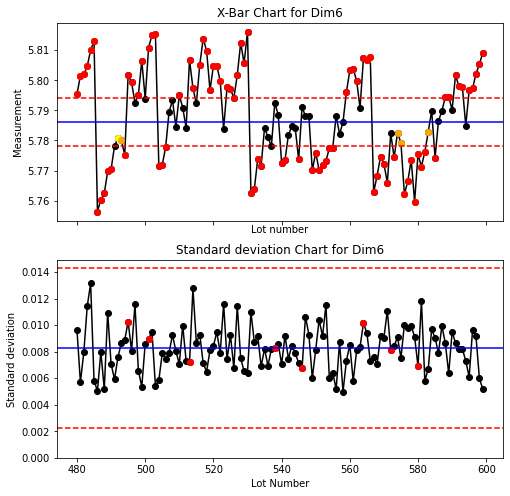

In [51]:
# Find 2 dimensions with the lowest total count of SPC Rules violations
worst = lot_params2.groupby('dim').mean().sort_values(by='SPC_Rule', ascending=False).iloc[0:2]

# Show  dimensions distribution on histogram with LSL and USL marked
for row, index in worst.iterrows():
    column = "Dim" + str(int(row))
    spc.hist(all_dims[column], column, dim_def.loc[row-1,'LSL'], dim_def.loc[row-1,'USL'], dim_def.loc[row-1,'Cp'], worst.loc[row, 'Ppk'])
    xb = spc.xBarS(all_dims, column, 120)

There is very distinct difference between the Best and Worst performing processes selected using either criteria. Processes with high average $P_{pk}$ values, tend to have wider tolerance band and lower amount of total process variation. They are not necessarly free of SPC Rule violations. SPC charts are designed to inform if the process is stable (free of special cause variation) but process that is not stable but has wide tolerance and is centered close to it's nominal can still have high $P_{pk}$ value (see Dim6).

#### Check the ability of SPC rules to detect the special causes


Below, I will divide the 'lot_params2' table into 2 parts:
- on_sample - part of the table that given SPC Rule is triggered
- off_sample - part of the table that given SPC Rule is equal to 0

Next, I will run a t-test for every special cause variable to see if there is a difference in the mean between these 2 samples. If the p-Value is smaller than 0.01, plot is displayed to show the difference in the distribution with mean highlighted.

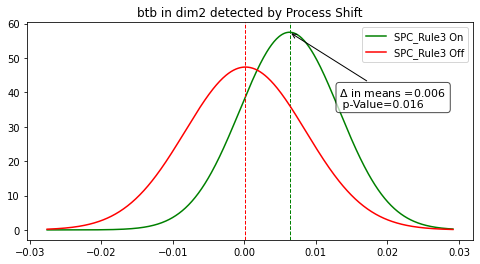

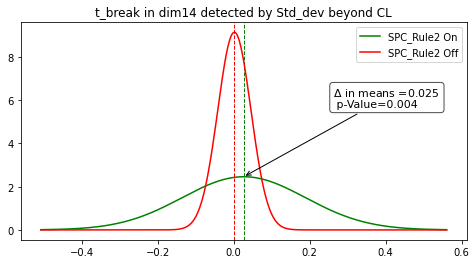

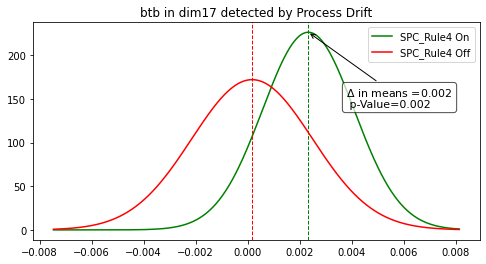

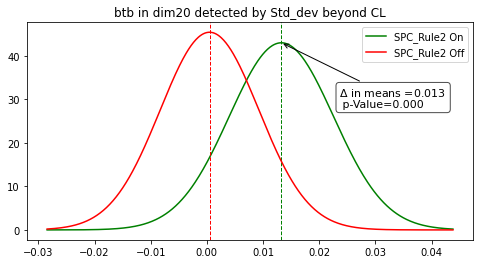

In [52]:
# define the signal columns, columns that are linked to the sources of variation
signal_col = ['btb', 'tcv', 't_break']
# define the detection columns: 5 Statistical Process Controll rules
detection_col = ['SPC_Rule1', 'SPC_Rule2', 'SPC_Rule3', 'SPC_Rule4', 'SPC_Rule5']
detection_txt = {'SPC_Rule1':'Mean beyond CL', 
                 'SPC_Rule2':'Std_dev beyond CL', 
                 'SPC_Rule3':'Process Shift',
                 'SPC_Rule4':'Process Drift', 
                 'SPC_Rule5':'Alternating process'
                }

# Loop through the dimensions
for dim in lot_params2.dim.unique(): 
    #loop through the detection columns
    single_dim = lot_params2[lot_params2['dim']==dim]
    for detect in detection_col: 
        # loop through the signal columns
        for signal in signal_col:       

            # take a slice of the DataFrame, where the signal is positive
            sample_on = single_dim[single_dim[detect]==1][signal]
            # take a slice of the DataFrame, where the signal is negative
            sample_off = single_dim[single_dim[detect]==0][signal]
            
            if (len(sample_on)>5) & (sample_on.sum()>0):
                if (len(sample_off)>5) & (sample_off.sum()>0):
                    # run the t-test 
                    ttest = ttest_ind(sample_on, sample_off)
                    # if p-value is smaller than 0.01, show the plot displying the difference in the mean

                    if ttest[1] < 0.05:
                        spc.show_mean_diff(sample_on, sample_off, signal+ ' in dim'+ str(dim)[:-2], detect, ttest[1], detection_txt)

Because the number scrapped parts per lot is not normally distributed (theoretically, it should have binomial distribution), I can't use the t-test to compare the scrap between the lots with and without SPC rules triggered. Instead, I will compare them graphically on the using histograms:

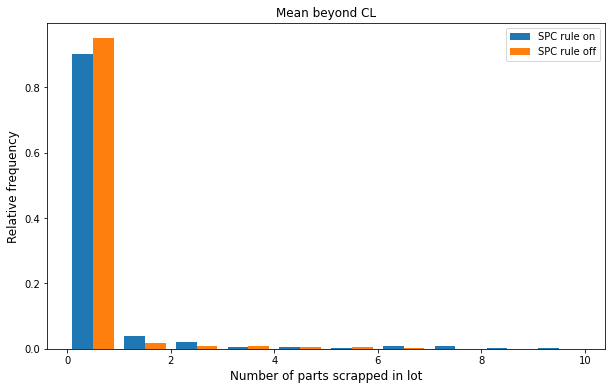

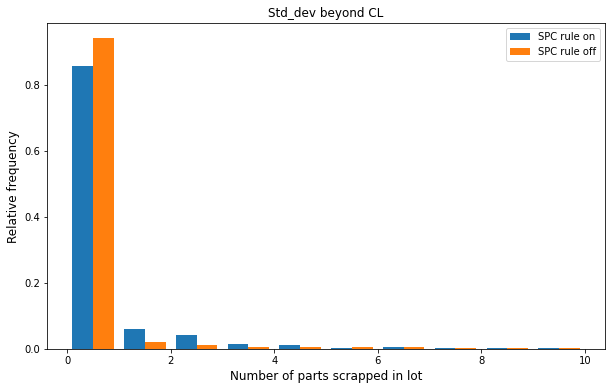

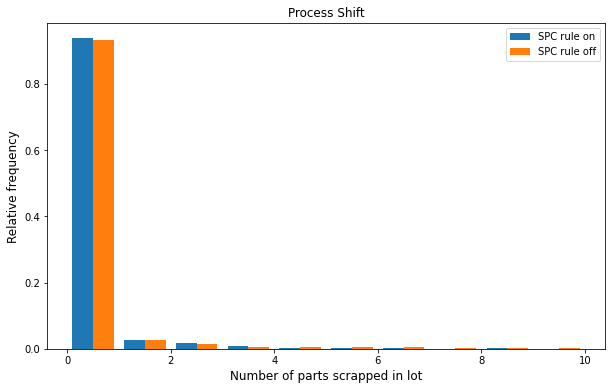

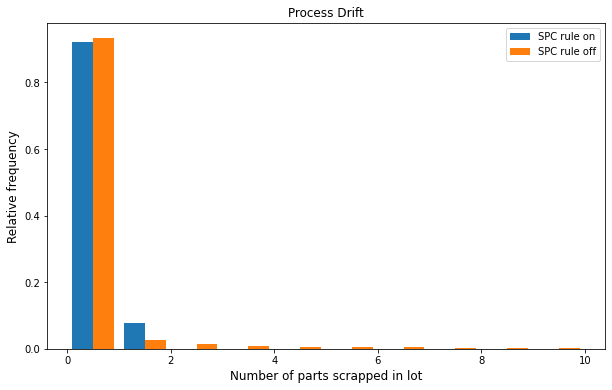

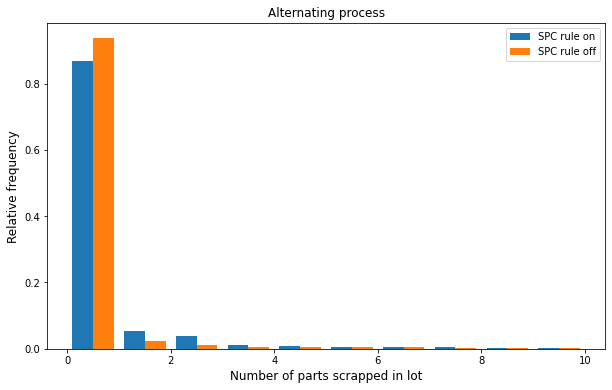

In [53]:
for det in detection_col:
    # create a new df from a slice of lot_params2 that has the SPC Rule triggered
    spc1_on = lot_params2[lot_params2[det]==1]
    # and other from the slice that doesn't have the SPC Rule triggered
    spc1_off = lot_params2[lot_params2[det]==0]

    # Create the instances of Figure and Axes objects
    fig, ax = plt.subplots(figsize=(10,6))
    
    # Set the Axes title
    ax.set_title(detection_txt[det])

    # initiate the empty list to hold 2 scrap list: one for SPC rule on and the other for SPC Rule off
    # in order to display 2 list on the same fistogram, they have to be added in the single list of lists
    scrap_list = []

    # Append both scrap lists (for SPC Rule on and off)
    scrap_list.append(spc1_on.Scrap)
    scrap_list.append(spc1_off.Scrap)

    # Create a histogram 
    ax.hist(scrap_list, density=True, label=['SPC rule on', 'SPC rule off'])
    
    #Set the Axis labels 
    ax.set_xlabel('Number of parts scrapped in lot', fontsize=12)
    ax.set_ylabel('Relative frequency', fontsize=12)

    # Add a legend
    ax.legend()

    # Shoe the graph
    plt.show()

#### Check the distribution of number of parts scrapped per lot (lot_params2.Scrap)

In [54]:
# probability of scrapping single part:
# Total number of scrapped parts divided by the number of parts in lot and number of lots
p = lot_params2.Scrap.sum()/10/len(lot_params2.Scrap)
print('p={:.3}'.format(p))

p=0.0193


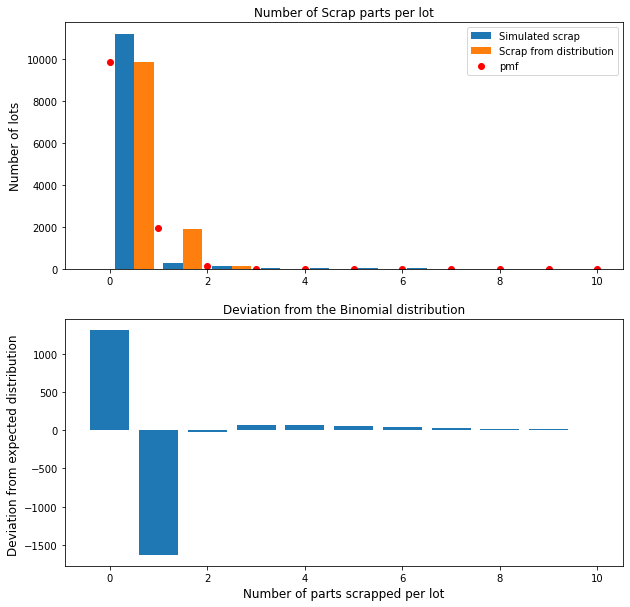

In [55]:
# Plot the histogram of the number of parts scrapped per lot
# And comapre it with the binomial distribution of the same parameters
fig, (ax, ax1 )= plt.subplots(2,1, figsize=(10,10))

# Create empty list to hold scrap values
scrap=[]

# Number of parts in a lot
n=10

# append the scrap values from the dimensions Simulation
scrap.append(lot_params2.Scrap.astype(int))

# append the scrap values calculated from the binomial distribution
scrap.append(rng.binomial(n, p, len(lot_params2.Scrap)) )

# plot the histogram, use 10 bins:0-1, ..., 9-10
h, bins, patches = ax.hist(scrap, 10, label=['Simulated scrap', 'Scrap from distribution'])

# calculate the value of probability mass function at all 11 bin edges: 0, 1,....,9, 10
y = binom.pmf(bins, n, p, loc=0)

# Multiply the values of pmf with the number of trials (number of lots)
# This way we'll get the expected number of 
ax.plot(bins, y*len(lot_params2.Scrap), 'ro', label='pmf')

#show the legend
ax.legend()

# Set the labels for the top plot

ax.set_ylabel('Number of lots', fontsize=12)

ax.set_title("Number of Scrap parts per lot")



# Set the labels for the bottom plot
ax1.set_ylabel('Deviation from expected distribution ', fontsize=12)
ax1.set_xlabel('Number of parts scrapped per lot', fontsize=12)

# Set the title for the bottom plot
ax1.set_title("Deviation from the Binomial distribution")

# match the axis on both subplots
# https://stackoverflow.com/questions/42973223/how-to-share-x-axes-of-two-subplots-after-they-have-been-created
ax1.get_shared_x_axes().join(ax1, ax)

# plot a bar chart, with diffrences between the heights of the simulated scrap distribution h[0]
# and scrap distribution calculated with binomial distribution h[1]
ax1.bar(bins[0:-1], h[0]-h[1])


plt.show()

As seen on the plot above, distribution of the number of parts scrapped per lot doesn't seem to be matching the Binomial distribution with the same probability of scrapping the part. I think the main reason is that the trials are not independent and the probability of scrap in each trial is not exactly the same: it can vary between the lots. There are random parameters (batch to batch variation, tool change variation, tool breakage) that change from lot to lot. Therefore, scrap in each lot is pooled from slightly different binomial distribution with probability of scrap that varies from lot to lot.

##### Compare tcv and btb values for lots without scrap and lots with scrap

To check if that's might be the case, let's compare the means of tool change variation (tcv) and batch to batch variation (btb) in lots with and without scrap.

In [56]:
no_scrap = lot_params2[lot_params2['Scrap']==0][['btb', 'tcv']]
no_scrap.head()

,btb,tcv
0,-0.009567,-0.019356
1,-0.006656,-0.019356
2,-0.022336,-0.019356
3,-0.006511,-0.019356
4,-0.006110,-0.019356


In [57]:
all_scrap = lot_params2[lot_params2['Scrap']>0][['btb', 'tcv']]
all_scrap.head()

,btb,tcv
16,-0.009383,-0.011261
17,-0.012593,-0.011261
29,0.040771,-0.007508
99,0.036197,-0.014790
225,0.036722,-0.000586


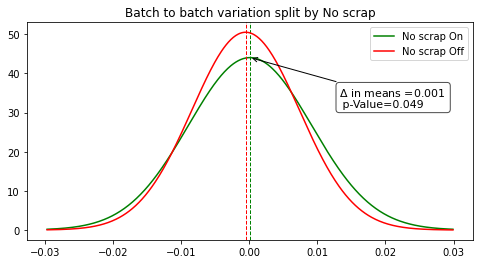

In [58]:
ttest = ttest_ind(no_scrap['btb'], all_scrap['btb'])
spc.show_mean_diff(no_scrap['btb'], all_scrap['btb'], 'Batch to batch variation', 'No scrap', ttest[1])

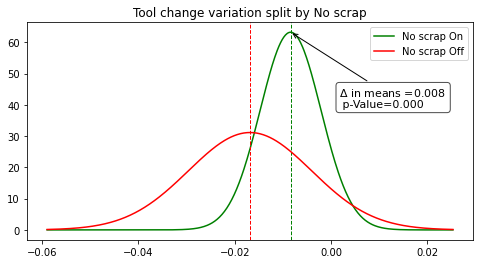

In [59]:
ttest = ttest_ind(no_scrap['tcv'], all_scrap['tcv'])
spc.show_mean_diff(no_scrap['tcv'], all_scrap['tcv'], 'Tool change variation', 'No scrap', ttest[1])

There seems to be statistically significant difference between the means of the tool change variation and batch to batch variation in lots without scrap and lots with scrapped parts. Let's see what is the distribution of both of these variables between both samples:

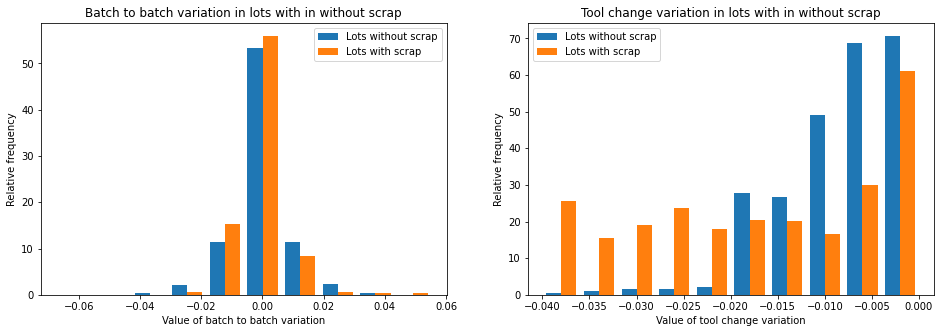

In [60]:
fig, (ax1, ax2 )= plt.subplots(1,2, figsize=(16,5))


# Compare the tool batch to batch variation
btb_list = []

btb_list.append(no_scrap['btb'])
btb_list.append(all_scrap['btb'])

n, bins, patches = ax1.hist(btb_list, density=True, label=['Lots without scrap', 'Lots with scrap'])

ax1.legend()

ax1.set_title("Batch to batch variation in lots with in without scrap")

ax1.set_ylabel('Relative frequency')
ax1.set_xlabel('Value of batch to batch variation')

# Compare the tool change variation
tcv_list = []

tcv_list.append(no_scrap['tcv'])
tcv_list.append(all_scrap['tcv'])

n, bins, patches = ax2.hist(tcv_list, density=True, label=['Lots without scrap', 'Lots with scrap'])

ax2.legend()

ax2.set_title("Tool change variation in lots with in without scrap")

ax2.set_ylabel('Relative frequency')
ax2.set_xlabel('Value of tool change variation')


plt.show()

The differences in the batch-to-batch variation are subtle but the differences in the distribution of tool change variation between the lots with and without scrap are clearly visible. There is over-representation of $tcv<-0.020$ in the lots that have scrapped parts. This would suggest that large absolute values of tool change variation could be correlated with dimension measurements being outside of the tolerance limits. That makes sense. this can explain the deviation of the distribution for the number of scrapped parts per lot from theoretical binomial distribution: probability of scrapping part is not the same in every lot as it varies between different dimensions (maximum values of tcv and btb are different for every dimension and we are looking at the scrapped parts for all dimensions) and it randomly changes after each tool changes within single dimension.

## 4. Predict if a lot will have nonconformant parts

#####  Create an input and output dataframes for the logistic regression

In [61]:
lot_params2

,btb,tcv,t_break,SPC_Rule,Scrap,St_dev,dim,tolerance,Cp,lots_per_tool,tool_tol,max_tool_wear,Ppk,SPC_Rule1,SPC_Rule2,SPC_Rule3,SPC_Rule4,SPC_Rule5
0,-0.009567,-0.019356,0.0,1,0.0,0.018675,1.0,0.1,1.730919,6.0,0.02,0.01,1.684450,1,0,0,0,0
1,-0.006656,-0.019356,0.0,0,0.0,0.018840,1.0,0.1,1.730919,6.0,0.02,0.01,1.680872,0,0,0,0,0
2,-0.022336,-0.019356,0.0,1,0.0,0.021956,1.0,0.1,1.730919,6.0,0.02,0.01,1.353839,1,0,0,0,0
3,-0.006511,-0.019356,0.0,1,0.0,0.022469,1.0,0.1,1.730919,6.0,0.02,0.01,1.478793,1,0,0,0,0
4,-0.006110,-0.019356,0.0,0,0.0,0.022242,1.0,0.1,1.730919,6.0,0.02,0.01,1.339025,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.005041,-0.012023,0.0,0,0.0,0.010059,20.0,0.1,2.355062,6.0,0.02,0.01,3.288876,0,0,0,0,0
596,0.002798,-0.012023,0.0,0,0.0,0.013511,20.0,0.1,2.355062,6.0,0.02,0.01,2.290127,0,0,0,0,0
597,-0.007176,-0.012023,0.0,0,0.0,0.012855,20.0,0.1,2.355062,6.0,0.02,0.01,2.468963,0,0,0,0,0
598,0.000207,-0.012023,0.0,0,0.0,0.011100,20.0,0.1,2.355062,6.0,0.02,0.01,2.910785,0,0,0,0,0


In [62]:
# Create a lot_x data frame using all the columns from lot_params2 bar the 'Scrap' column
lot_in = pd.DataFrame(lot_params2.drop(columns=['Scrap', 'dim']))
# Use only 'Scrap' column to create lot_y data frame
lot_out = lot_params2['Scrap']

# Replace all the values were scrap is larger than 0 with 1:
# 0 - no scarpped part in the lot
# 1 - lot has scrapped parts

lot_out.loc[lot_out>0]=1

C:\Users\Przemek\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#####  Use DecisionTreeClassifier to select features that have the largest

In [63]:
dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10)
dt.fit(lot_in, lot_out)

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [64]:
# Initialize feature importance DataFrame
fi = pd.DataFrame(columns = ['Feature','Feature Importance'])

for i, column in enumerate(lot_in):
    
    fi.loc[i, 'Feature'] = column
    fi.loc[i, 'Feature Importance'] = dt.feature_importances_[i]

fi.sort_values(by='Feature Importance', ascending=False, inplace=True, ignore_index=True)

In [65]:
# Show the Feature importance table
fi

,Feature,Feature Importance
0,Ppk,0.951557
1,St_dev,0.0172
2,tcv,0.011108
3,btb,0.01013
4,SPC_Rule3,0.003309
5,Cp,0.002546
6,lots_per_tool,0.001755
7,tolerance,0.001207
8,max_tool_wear,0.000657
9,SPC_Rule2,0.00053


In [66]:
# keep only column that have their 'Feature Importance' greater than 0
fi = fi[fi['Feature Importance']>0]

# Create a use_column series, which holds names of the columns that have feature importance larger than 0
use_column = fi['Feature']
use_column

0              Ppk
1           St_dev
2              tcv
3              btb
4        SPC_Rule3
5               Cp
6    lots_per_tool
7        tolerance
8    max_tool_wear
9        SPC_Rule2
Name: Feature, dtype: object

#####  Split the data for training and validation sets

In [67]:
X = lot_params2[use_column]
Y = lot_params2['Scrap']

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size=0.2)

In [69]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(9600, 10)
(9600,)
(2400, 10)
(2400,)


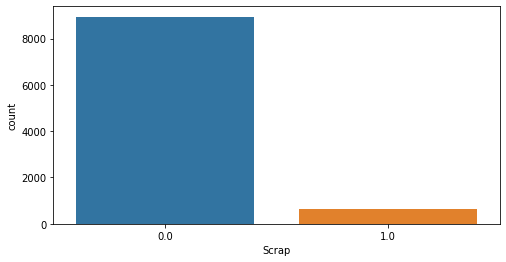

In [70]:
# Let's check if the 0s and 1s in Y_train is evenly distributed 
sns.countplot(x=Y_train)
plt.show()

They are not evenly distributed. The training dataset will need to be balanced.

##### Balance the training dataset

Training dataset is heavily imbalanced towards 0: most of the lots don't have any scrapped parts. This can lead to trained model to be strongly skewed towards the majority class and never to predict the 1.

Balancing completed by undersampling the majority class as per: https://towardsdatascience.com/how-to-deal-with-imbalanced-data-in-python-f9b71aba53eb

In [71]:
undersample = RandomUnderSampler(sampling_strategy = 'majority')

In [72]:
X_train_under, Y_train_under = undersample.fit_resample(X_train, Y_train)

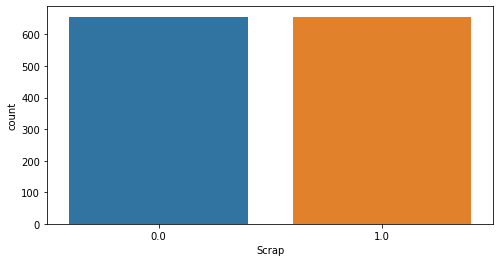

In [73]:
# Let's check if the Y is evenly distributed 
sns.countplot(x=Y_train_under)
plt.show()

#####  Run logistic Regression on balanced training dataset

In [74]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# Initialize the logistic regression
log_reg = LogisticRegression(solver = 'lbfgs', C=1)

log_reg.fit(X_train_under, Y_train_under)

LogisticRegression(C=1)

In [75]:
# predict - Predict class labels for samples in X
y_pred = log_reg.predict(X_train)

In [76]:
# Classification Report
print(classification_report(Y_train, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      8944
         1.0       0.64      1.00      0.78       656

    accuracy                           0.96      9600
   macro avg       0.82      0.98      0.88      9600
weighted avg       0.98      0.96      0.97      9600



#####  Hyper parameters tuning

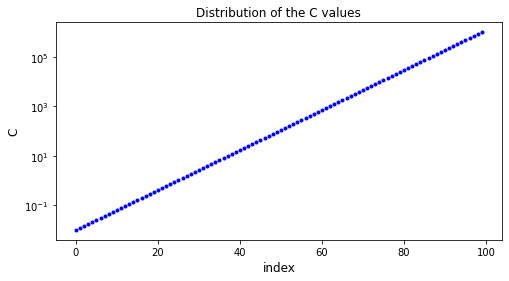

In [77]:
# define a list of c values (inverse of regularization strength) to run the model training with
c_values = np.geomspace(1e-2, 1e6, num=100)

# Show the distribution of the c values on the logarithmic scale
fig, ax = plt.subplots()

ax.plot(c_values, 'b.')
ax.set_yscale('log')

# Set the labels on the Axis
ax.set_xlabel('index', fontsize=12)
ax.set_ylabel('C', fontsize=12)

# Add the title to the Axes
ax.set_title('Distribution of the C values')

plt.show()

In [78]:
%%time
# Measure and display the calculation time

# To switch off convergence warning. For some of the combinations of the Hyper Parameters
# algoritm fails to converge. I'm suppressing this warning type as loop below would result in  tens of these
# warnings being displayed
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

scores_df = pd.DataFrame(columns = ['C', 'max_iter','Score', 'Log loss'])
scores = []
Logarithmic_Loss = []

i = 0

for c in c_values:
    for max_it in np.random.randint(20, 400, 10):
        scores_df.loc[i, 'C'] = c
        scores_df.loc[i, 'max_iter'] = max_it

        # Train the model using c value
        log_reg = LogisticRegression( solver = 'lbfgs', warm_start=True, C=c, max_iter=max_it)
        log_reg.fit(X_train_under, Y_train_under)

        # score the trained model
        score = log_reg.score(X_test, Y_test)
        scores_df.loc[i, 'Score'] = score

        # calculate the logarithmic loss function
        pred_proba_t = log_reg.predict_proba(X_test)
        scores_df.loc[i, 'Log loss'] = log_loss(Y_test, pred_proba_t)

        i+=1

Wall time: 41.9 s


##### Find the parameters that yield the highest score

In [79]:
# Sort the scores df by the 'Score' value, largest on the top
scores_df.sort_values(by='Score', ascending=False, inplace=True)
max_score = scores_df.iloc[0,:]
scores_df.head(10)

,C,max_iter,Score,Log loss
712,5462.277218,21,0.970417,0.075586
990,1000000.0,20,0.970417,0.075636
730,7924.828984,47,0.97,0.079209
771,16681.005372,47,0.97,0.078562
568,335.160265,24,0.97,0.075097
716,5462.277218,43,0.969583,0.079341
708,4534.878508,39,0.969583,0.079289
707,4534.878508,36,0.969583,0.079125
689,3125.71585,26,0.969583,0.074914
671,2595.024211,46,0.969583,0.078045


##### Fine the parameters that yield the lowest logarithmic loss

In [80]:
# Sort the scores df by the 'Log loss value' value, largest on the top
scores_df.sort_values(by='Log loss', ascending=True, inplace=True)
min_logloss = scores_df.iloc[0,:]
scores_df.head(10)

,C,max_iter,Score,Log loss
407,17.073526,20,0.96625,0.074866
689,3125.71585,26,0.969583,0.074914
568,335.160265,24,0.97,0.075097
712,5462.277218,21,0.970417,0.075586
990,1000000.0,20,0.970417,0.075636
852,73907.220335,23,0.969583,0.075812
607,705.480231,22,0.969583,0.07593
916,225701.971963,22,0.969583,0.075936
628,1023.531022,22,0.969583,0.075937
867,89021.508545,77,0.969583,0.077185


##### Display the Score and log_loss on the scatter plot of Hyper Parameters

In [81]:
# Calculate the parametrs for mapping the log_loss value to the markers size

# Calculate min and max values for the 'log loss' column
ll_min = scores_df['Log loss'].min()
ll_max = scores_df['Log loss'].max()

# define what will be the largest and smallest marker sizes
p_max = 0.01                            # max marker size will be 1/p_max
p_min = 1                                # min marker size will be 1/p_min 

# calculate the parameters for the linear transformation
# the goal is to transform:
# ll_min ---> p_max
# ll_max ---> p_min
a = (p_max-p_min)/(ll_min-ll_max)
b = p_min - a * ll_max

# These parameters will be used in the functions f and g belowS

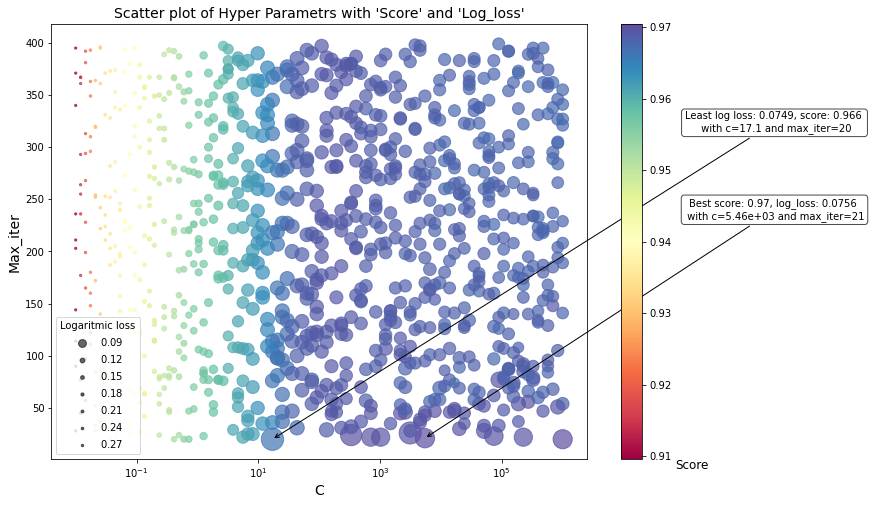

In [82]:
# Plot created with help of this article:
# https://www.tutorialspoint.com/how-can-i-convert-numbers-to-a-color-scale-in-matplotlib
fig, ax = plt.subplots(figsize=(12,8))

cmap = plt.cm.Spectral
norm = colors.Normalize(vmin=scores_df.Score.min(), vmax=scores_df.Score.max())

# Function f will map the log_loss values to the size of the marker
# Function g will reverse this mapping to display correct values on th elegend

scale = 5

# the goal is to have a lot of small and few really large points, large points will represent the smallest values of log_loss
# this mapping will make it easier to see which combinations of hyper parameters yield the best results
f = lambda l: np.reciprocal(l * a + b)*scale

# Function f and g defined to recalculate the size of the marker and scale it back for the label on th elegend
# https://stackoverflow.com/questions/59428303/how-to-scale-legend-elements-down-in-a-scatterplot-matplotlib
g = lambda s: (scale*np.reciprocal(s)- b)*np.reciprocal(a)

# convert dtype object to number as per: 
# https://stackoverflow.com/questions/25952790/convert-pandas-series-from-dtype-object-to-float-and-errors-to-nans
scatter = ax.scatter(scores_df.C,
           scores_df.max_iter, 
           color = cmap(norm(pd.to_numeric(scores_df.Score))),
           s = f(pd.to_numeric(scores_df['Log loss'])),
                     alpha=0.7
          )


# Add the Legend for the colours
# https://stackoverflow.com/questions/15908371/matplotlib-colorbars-and-its-text-labels
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm)

# Add the 'Score' title to the side colour bar
cbar.set_label('Score', fontsize=12, loc='bottom', rotation='horizontal')


#Add legend for the marker size

# produce a legend with a cross section of sizes from the scatter
# from https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html
handles, labels = scatter.legend_elements("sizes",                 # options are: 'color' or 'sizes', we'll use 'sizes'
                                          alpha=0.6,               # opacity of this legend
                                          num=8,                   # number of markers to be displayed
                                          func=g                   # recalculate the labels for the markers size back to the log_loss values
                                         )

# Add second legend that represents the size of the markers
legend2 = ax.legend(handles,                                       # list of Artists (patches) to be added to the legend
                    labels,                                        # list of labels to be added to the legend
                    loc="lower left",                              # location of the legend
                    title="Logaritmic loss")                       # The title of th elegend


# Set the labels on the Axis
ax.set_xlabel('C', fontsize=14)
ax.set_ylabel('Max_iter', fontsize=14)

# Set the X scale to log
ax.set_xscale('log')

# Add the title to the Axes
ax.set_title("Scatter plot of Hyper Parametrs with 'Score' and 'Log_loss'", fontsize=14)

# Add annotations

# Get the parameters for the annotation text
c_max, iter_max, score_max, loss_min = max_score

# Annotations added as per:
# https://matplotlib.org/stable/tutorials/text/annotations.html
ax.annotate('Best score: {:.3}, log_loss: {:.3} \n with c={:.3} and max_iter={}'.format(score_max, loss_min, c_max, iter_max),    # Text to be put in the annotation
            xy=(c_max, iter_max),  xycoords='data',                                            # coordinates of the data point 
            xytext=(1.35, 0.6), textcoords= 'axes fraction',                                    # coordinates of the text
            arrowprops=dict(facecolor='black',  arrowstyle="->", connectionstyle="arc3"),      # parameters of the arrow
            horizontalalignment='center', verticalalignment='top',                             # alignment of the text to the 'xytext' coordinates
            bbox=dict(boxstyle="round", fc="w", alpha=0.7)                                     # parameters of the box around the text
            )

# Get the parameters for the annotation text
c_max, iter_max, score_max, loss_min = min_logloss

# Annotations added as per:
# https://matplotlib.org/stable/tutorials/text/annotations.html
ax.annotate('Least log loss: {:.3}, score: {:.3} \n with c={:.3} and max_iter={}'.format(loss_min, score_max, c_max, iter_max),    # Text to be put in the annotation
            xy=(c_max, iter_max),  xycoords='data',                                            # coordinates of the data point 
            xytext=(1.35, 0.8), textcoords= 'axes fraction',                                    # coordinates of the text
            arrowprops=dict(facecolor='black',  arrowstyle="->", connectionstyle="arc3"),      # parameters of the arrow
            horizontalalignment='center', verticalalignment='top',                             # alignment of the text to the 'xytext' coordinates
            bbox=dict(boxstyle="round", fc="w", alpha=0.7)                                     # parameters of the box around the text
            )


plt.show()

##### Validate the results with confusion matrix

Predict the scrap using trained model and compare it with the actual scrap

In [83]:
# Create and fit 2 models using parameters from Hyper Tuning for the highest score and the least log_loss
best_score_model = LogisticRegression(solver = 'lbfgs', warm_start=True, C=max_score[0], max_iter=max_score[1])
best_score_model.fit(X_train_under, Y_train_under)

least_logloss_model = LogisticRegression(solver = 'lbfgs', warm_start=True, C=min_logloss[0], max_iter=min_logloss[1])
least_logloss_model.fit(X_train_under, Y_train_under)

LogisticRegression(C=17.07352647470692, max_iter=20, warm_start=True)

In [84]:
# This function is from: https://www.youtube.com/watch?v=NPdn3YPkg9w
# Confusion Matrix function

def plot_confusion_matrix(cm, classes=None, title='Confusion matrix', normalize=True):
        
    # Normalize the confusion matrix, to have values between 0 and 1
    if normalize:
        cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
        v_min = 0.
        v_max = 1.
        fmt_string = ".2f"
    else:
        cm_norm = cm
        v_min=0.
        v_max=cm.max()
        fmt_string = "d"
    
    fig, ax = plt.subplots(figsize=(8,6))
    
    if classes is not None:
        sns.heatmap(cm_norm, cmap="RdYlGn", xticklabels=classes, yticklabels=classes, vmin=v_min, vmax=v_max, annot=True, fmt=fmt_string, annot_kws={'size':15})
    else:
        sns.heatmap(cm_norm, vmin=0., vmax=1.)
        
    # Set the title
    ax.set_title(title)
    
    # Set the label to the X and Y Axis
    ax.set_xlabel('Predicted label', fontsize=12)
    ax.set_ylabel('True label', fontsize=12)
    
    plt.show()

In [85]:
#Predict if the lot would have scrapped parts using the 'best score model':
Y_predict = best_score_model.predict(X_train)

conf_matrix = confusion_matrix(Y_train, Y_predict)

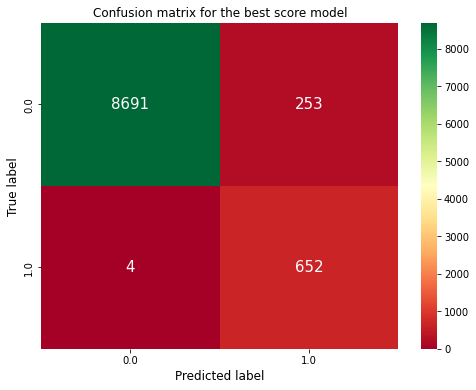

In [86]:
# Plot confusion matrix for the 'Best score model'
plot_confusion_matrix(conf_matrix, classes = log_reg.classes_, title='Confusion matrix for the best score model', normalize=False)

In [87]:
# Print classification report
cr_dict = classification_report(Y_train, Y_predict, output_dict = True)
print(classification_report(Y_train, Y_predict))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99      8944
         1.0       0.72      0.99      0.84       656

    accuracy                           0.97      9600
   macro avg       0.86      0.98      0.91      9600
weighted avg       0.98      0.97      0.98      9600



In [88]:
#Predict if the lot would have scrapped parts using the 'least logaritmic loss model':
Y_predict = least_logloss_model.predict(X_train)

conf_matrix = confusion_matrix(Y_train, Y_predict)

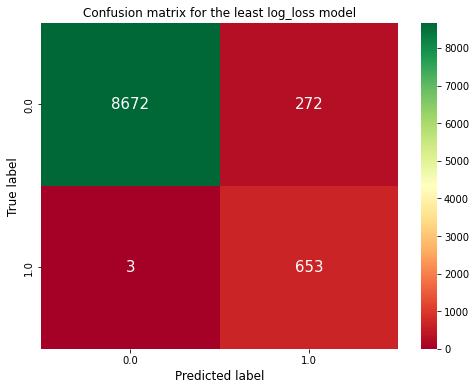

In [89]:
# Plot confusion matrix for the 'Best score model'
plot_confusion_matrix(conf_matrix, classes = log_reg.classes_, title='Confusion matrix for the least log_loss model', normalize=False)

In [90]:
# Print classification report
cr_dict = classification_report(Y_train, Y_predict, output_dict = True)
print(classification_report(Y_train, Y_predict))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      8944
         1.0       0.71      1.00      0.83       656

    accuracy                           0.97      9600
   macro avg       0.85      0.98      0.91      9600
weighted avg       0.98      0.97      0.97      9600



## 5. References

[[1] Implementing Six Sigma, Smarter Solutions Using Statistical Methods, Forrect W. Breyfogle III](https://www.amazon.co.uk/Implementing-Six-Sigma-Solutions-Statistical/dp/B07YXBN4YY/ref=sr_1_1?keywords=implementing+six+sigma&qid=1640876748&sr=8-1)</br>
[[2] VARIABILITY IN MANUFACTURING](https://link.springer.com/referenceworkentry/10.1007%2F1-4020-0612-8_1032#Chap1031_1-4020-0612-8_1031)</br>

# End